# Setup

Retrieve "GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv" from [this GitHub link](https://github.com/nasa/GeneLab_Data_Processing/blob/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files/GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv) and save it in the same directory as this notebook. The GitHub path is `nasa/GeneLab_Data_Processing/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files`.



Possible Map My Cells region keys = ["RHP", "RSP", "ACA", "PL-ILA-ORB", "AUD-TEa-PERI-ECT", "SS-GU-VISC", "MO-FRP", "PAL", "sAMY", "CTXsp", "HY", "STRv", "OLF", "LSX", "AI", "STRd", "VIS-PTLp", "VIS", "TH", "MOp", "ENT", "HIP", "P", "MB", "MY", "CB", "AUD", "SSp", "TEa-PERI-ECT"]

---

**Use Conda**

While in the folder containing this notebook:
`conda env create -f rapidsc.yml`



Navigate back to where you want to clone the `scflow` repository (I recommend home)
`cd`

Clone `scflow` from GitHub.
`git clone git@github.com:easlinger/scflow.git`

Navigate to the folder where `scflow` is:
`pip install .`

`pip install senepy`

---

**For NVIDIA Drivers (Linux)**

```
sudo apt update
sudo apt install -y build-essential dkms

sudo apt install -y wget
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"

sudo apt update
sudo apt install -y cuda
```

---


## Imports & Display

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import re
import logging
import json
try:
    import torch
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import scflow

pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)


class CategoricalFilter(logging.Filter):
    def filter(self, record):
        return "storing" not in record.getMessage() or \
               "as categorical" not in record.getMessage()


logger = logging.getLogger("anndata")
logger.addFilter(CategoricalFilter())

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_nam

## Set Options (ACTIVELY SET THESE!)

In [2]:
# Processors to Use
n_processors = os.cpu_count() - 1  # how many processors to use

# If You Want Results Emailed
cur_file = os.path.join(os.path.abspath(""), "create_object_613.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Set Data Sources & Species
species = "Mouse"
batches = ["OSD-613"]  # in list even if just 1, or list multiple to integrate

# Set Source Data Directory & Output Options
superdirec = "/home/easlinger/data"  # directory with original data
direcs = [os.path.join(superdirec, i) for i in batches]
# new h5ad will write to "data" sub-directory of where this notebook is
overwrite = True  # allow overwrite of files?
file_concat = os.path.join("data", f"{'_'.join(batches)}_concatenated.h5ad")
file_new = os.path.join("data", f"{'_'.join(batches)}_integrated.h5ad")

# Set Sample & Batch IDs, Plus Other Potential Sources of Batch Effects
col_group = "Group"  # age &/or space flight
col_age = "Characteristics[Age at Euthanasia]"
# col_age = "Factor Value[Age]"
col_condition = "Factor Value[Spaceflight]"
col_sample = "sample"
col_batch = "batch" if len(
    batches) > 1 else col_group  # group=batch if 1 dataset
covariates_categorical = ["Comment[Euthanasia Date]"]
# covariates_categorical = None

# Do Sub-Clustering?
# subcluster_biggest = 1  # sub-cluster biggest cluster
# subcluster_biggest = 3  # sub-cluster biggest 3 clusters
subcluster_biggest = False  # no sub-clustering
kws_cluster = dict()  # cluster individual samples
# kws_cluster = None  # do not cluster individual samples

# Set Annotation Sources
map_my_cells_source = "WMB-10X" if species == "Mouse" else "WHB-10X" if (
    species == "Human") else None  # Map My Cells atlas source
# map_my_cells_region_keys = None
map_my_cells_region_keys = [
    "RSP", "ACA", "PL-ILA-ORB", "AUD-TEa-PERI-ECT", "SS-GU-VISC", "MO-FRP",
    "AI", "VIS-PTLp", "VIS", "MOp", "AUD", "SSp",
    "TEa-PERI-ECT"]  # regional subset for Map My Cells
map_my_cells_cell_keys = ["Isocortex"]  # pattern match: feature name column
if species == "Mouse":
    model_celltypist = "Mouse_Whole_Brain.pkl"
else:
    raise ValueError("Manually set CellTypist model for non-mouse!")
source_patterns = ["Brain", "Cortical", "cortex"]  # for ToppGene

# Make Pre-Defined Marker Dictionary
cts_superhierarchical = {
    "Neuron": ["Excitatory", "Inhibitory", "Glutamatergic", "GABAergic",
               "Dopaminergic", "Serotonergic", "Cholinergic"]
}  # if classified as Neuron + other, just keep more specific type(s)
rename_marker_based_annotation = {
    "Excitatory | Inhibitory": "Excitatory-Inhibitory",
    "Inhibitory | Inhibitory": "Excitatory-Inhibitory"
}
mks_a_priori = pd.read_csv("GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv")
mks_a_priori.loc[:, "cellName"] = mks_a_priori.cellName.replace({
    "Oligodendrocyte precursor cell": "OPC"}).apply(
        lambda x: " ".join([i.capitalize() for i in re.sub(
            " cell", "", x).split(" ")])).replace({
                "Opc": "OPC"})  # capitalize cell names
mks_a_priori = mks_a_priori.set_index("cellName")["geneSymbol"]
mks_a_priori = dict(mks_a_priori.apply(lambda x: set(x.split(","))))
mks_a_priori.update({
    "Neuroepithelial": {"Nes", "Notch1", "Sox2", "Sox10", "Hes1", "Hes3"},
    "Excitatory": {"Slc17a7", "Slc30a3", "Tcf4",
                   "Slc17a6", "Slc6a1", "Baiap3",
                   "Grin1", "Grin2b", "Gls"},
    "Inhibitory": {"Gad1", "Slc6a1", "Gabbr1", "Gabbr2",
                   "Gad2", "Slc32a1", "Oprm1", "Htr2c"},
    # "Glutamatergic": {"Slc17a7", "Slc17a6", "Grin1", "Grin2b", "Gls"},
    # "GABAergic": {"Slc6a1", "Gabbr1", "Gabbr2", "Gad2", "Gad1"},
    # "Dopaminergic": {"Th", "Dat", "Foxa2", "Girk2", "Nurr1", "Lmx1b"},
    # "Serotonergic": {"Tph", "Sert", "Pet1"},
    # "Cholinergic": {"ChAT", "VAChT", "Acetylcholinesterase"}
})
markers_predefined = {**mks_a_priori}
if cts_superhierarchical is not None:
    for i in cts_superhierarchical:
        for k in [u for u in cts_superhierarchical[
                i] if u in markers_predefined]:
            markers_predefined[k] = markers_predefined[k].union(
                markers_predefined[i])
    _ = [markers_predefined.pop(i) for i in cts_superhierarchical]
mks_collapsed = {**mks_a_priori}
mks_collapsed["Neuron"] = mks_collapsed["Neuron"].union(mks_collapsed[
    "Excitatory"]).union(mks_collapsed["Inhibitory"])
_ = mks_collapsed.pop("Excitatory")
_ = mks_collapsed.pop("Inhibitory")

## Load Individual Sample Data

In [3]:
%%time

# Create a Subdirectory of Working Directory for Data Outputs
os.makedirs("data", exist_ok=True)

# Get Metadata
metadata = [pd.read_csv(os.path.join(
    superdirec, f"{i}_metadata_{i}-ISA/s_{i}.txt"), sep=None,
                        engine="python").set_index("Source Name").rename_axis(
                            col_sample) for i in batches]  # list of metadata
for u in np.arange(len(metadata)):  # add a combined age & condition variable
    metadata[u] = metadata[u].join(metadata[u].apply(
        lambda x: x[col_condition] + str(
            " | " + str(x[col_age]) + " Weeks" if (
                col_age in metadata[u].columns and len(
                    metadata[u][col_age].unique()) > 1) else ""),
        axis=1).to_frame(col_group))  # add space flight (x age if applicable)

# Load Data
adatas, files = {}, {}
for u, d in enumerate(direcs):  # iterate directories, then samples within
    for x in [i for i in os.listdir(d) if os.path.isdir(os.path.join(d, i))]:
        ddd = [os.path.join(d, x, i) for i in os.listdir(os.path.join(d, x))]
        if len(ddd) > 1:  # ensure 1 subdirectory (for the sample) in folder
            raise ValueError(f"More than one file: {ddd}")
        sample = os.path.basename(os.path.join(d, x, ddd[0]))  # sample ID
        files[sample] = os.path.join(os.path.join(d, x, ddd[0]),
                                     "filtered_feature_bc_matrix.h5")  # file
        adatas[sample] = sc.read_10x_h5(files[sample])  # read anndata (h5)
        if col_batch:  # if a batch column specified
            adatas[sample].obs.loc[:, col_batch] = batches[u]  # batch => .obs
        adatas[sample].obs.loc[:, col_sample] = sample  # sample ID => .obs
        samp_metadata = metadata[u].loc[sample] if (
            sample in metadata[u].index.values) else metadata[u].set_index(
                "Sample Name").loc[sample]  # extract sample-specific metadata
        for v in samp_metadata.index.values:  # loop metadata => .obs columns
            adatas[sample].obs.loc[:, v] = samp_metadata.loc[v]
        adatas[sample].obs.loc[:, f"n_cells_original_{col_sample}"] = adatas[
            sample].obs.shape[0]  # original number of cells
print(files)
metadata

{'RRRM2_BRN_GC_ISS-T_YNG_GY4': '/home/easlinger/data/OSD-613/RRRM2_BRN_GC_ISS-T_YNG_GY4-20250307T191036Z-001/RRRM2_BRN_GC_ISS-T_YNG_GY4/filtered_feature_bc_matrix.h5', 'RRRM2_BRN_GC_ISS-T_YNG_GY9': '/home/easlinger/data/OSD-613/RRRM2_BRN_GC_ISS-T_YNG_GY9-20250307T192252Z-001/RRRM2_BRN_GC_ISS-T_YNG_GY9/filtered_feature_bc_matrix.h5', 'RRRM2_BRN_GC_ISS-T_OLD_GO18': '/home/easlinger/data/OSD-613/RRRM2_BRN_GC_ISS-T_OLD_GO18-20250307T185055Z-001/RRRM2_BRN_GC_ISS-T_OLD_GO18/filtered_feature_bc_matrix.h5', 'RRRM2_BRN_FLT_ISS-T_OLD_FO20': '/home/easlinger/data/OSD-613/RRRM2_BRN_FLT_ISS-T_OLD_FO20-20250307T162503Z-001/RRRM2_BRN_FLT_ISS-T_OLD_FO20/filtered_feature_bc_matrix.h5', 'RRRM2_BRN_GC_ISS-T_OLD_GO19': '/home/easlinger/data/OSD-613/RRRM2_BRN_GC_ISS-T_OLD_GO19-20250307T185555Z-001/RRRM2_BRN_GC_ISS-T_OLD_GO19/filtered_feature_bc_matrix.h5', 'RRRM2_BRN_GC_ISS-T_OLD_GO13': '/home/easlinger/data/OSD-613/RRRM2_BRN_GC_ISS-T_OLD_GO13-20250307T164505Z-001/RRRM2_BRN_GC_ISS-T_OLD_GO13/filtered_featu

[                                    Sample Name Characteristics[Organism] Term Source REF                              Term Accession Number Characteristics[Strain] Term Source REF.1  \
 sample                                                                                                                                                                                   
 RRRM-2_FL_ISS_14   RRRM2_BRN_FLT_ISS-T_OLD_FO14              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...             C57BL/6NTac               EFO   
 RRRM-2_FL_ISS_16   RRRM2_BRN_FLT_ISS-T_OLD_FO16              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...             C57BL/6NTac               EFO   
 RRRM-2_FL_ISS_17   RRRM2_BRN_FLT_ISS-T_OLD_FO17              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...             C57BL/6NTac               EFO   
 RRRM-2_FL_ISS_19   RRRM2_BRN_FLT_ISS-T_OLD_FO19              Mus

# QC

## Perform Sample-Specific QC

Variable                                                       n_cells_by_counts  n_genes_by_counts  pct_counts_mt  total_counts
sample                       Group                     Metric                                                                   
RRRM2_BRN_FLT_ISS-T_OLD_FO14 Space Flight | 37 Weeks   count             56748.0             4260.0         4260.0        4260.0
                                                       mean                228.0             3040.0            2.0       10679.0
                                                       std                 548.0             1730.0            3.0        9449.0
                                                       min                   0.0                5.0            0.0           5.0
                                                       2.5%                  0.0              719.0            0.0        1129.0
                                                       10%                   0.0              931.0            0.0        1641.0
                                                       25%                   0.0             1271.0            0.0        2478.0
                                                       50%                   3.0             3182.0            1.0        8793.0
                                                       75%                 109.0             4415.0            2.0       15769.0
                                                       85%                 440.0             4972.0            3.0       20076.0
                                                       90%                 802.0             5327.0            4.0       23291.0
                                                       97.5%              2114.0             6255.0           10.0       33911.0
                                                       max                4252.0             9857.0           46.0       69813.0
RRRM2_BRN_FLT_ISS-T_OLD_FO16 Space Flight | 37 Weeks   count             56748.0             4863.0         4863.0        4863.0
                                                       mean                288.0             3358.0            4.0       11512.0
                                                       std                 671.0             1890.0            6.0       10039.0
                                                       min                   0.0               71.0            0.0         139.0
                                                       2.5%                  0.0              766.0            0.0        1213.0
                                                       10%                   0.0              983.0            0.0        1710.0
                                                       25%                   0.0             1396.0            1.0        2727.0
                                                       50%                   3.0             3551.0            3.0        9776.0
                                                       75%                 130.0             4796.0            6.0       16856.0
                                                       85%                 601.0             5431.0            8.0       21349.0
                                                       90%                1077.0             5831.0           10.0       24861.0
                                                       97.5%              2573.0             6861.0           20.0       36130.0
                                                       max                4861.0             9750.0           66.0       97274.0
RRRM2_BRN_FLT_ISS-T_OLD_FO17 Space Flight | 37 Weeks   count             56748.0             1493.0         1493.0        1493.0
                                                       mean                 37.0             1423.0            4.0        3043.0
                                                       std                 106.0             1042.0            4.0        3380.0
 

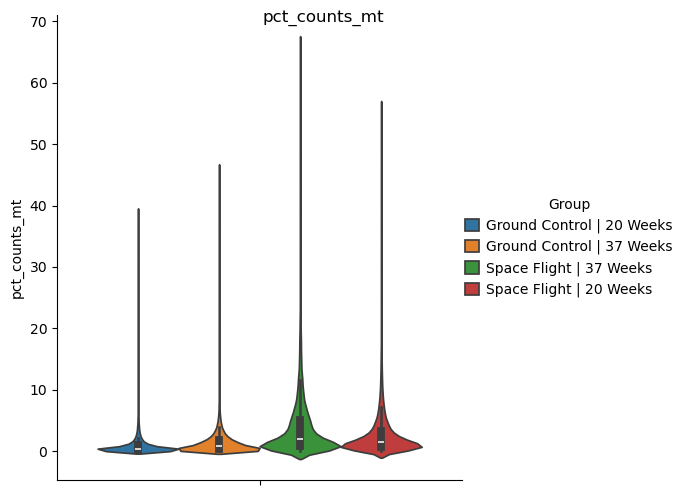

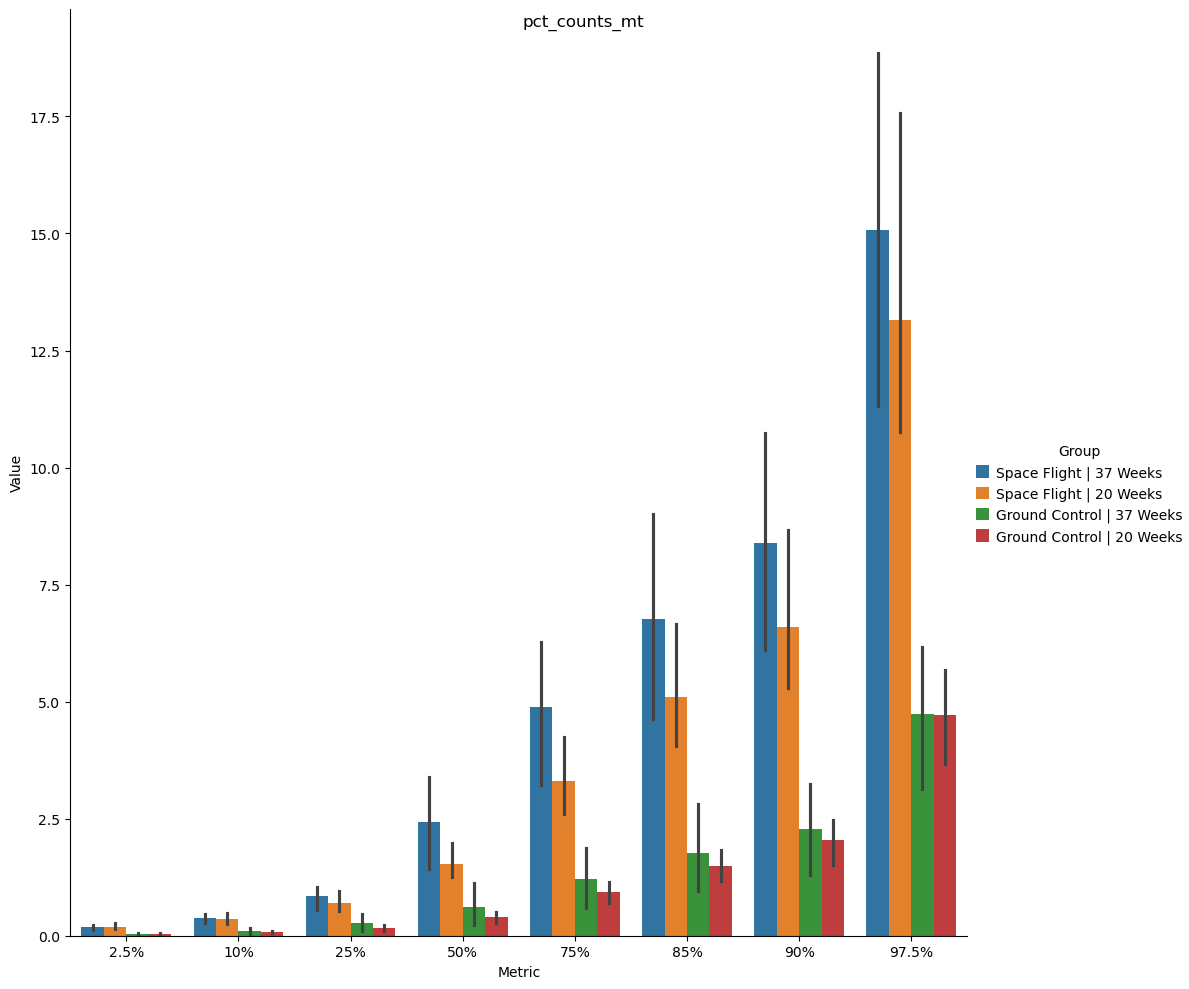

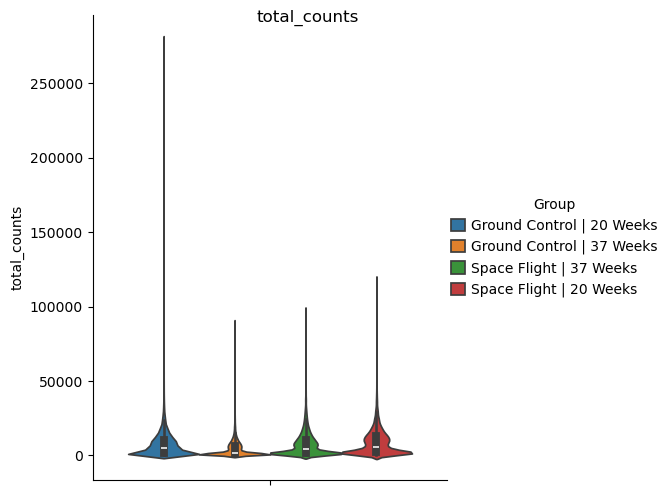

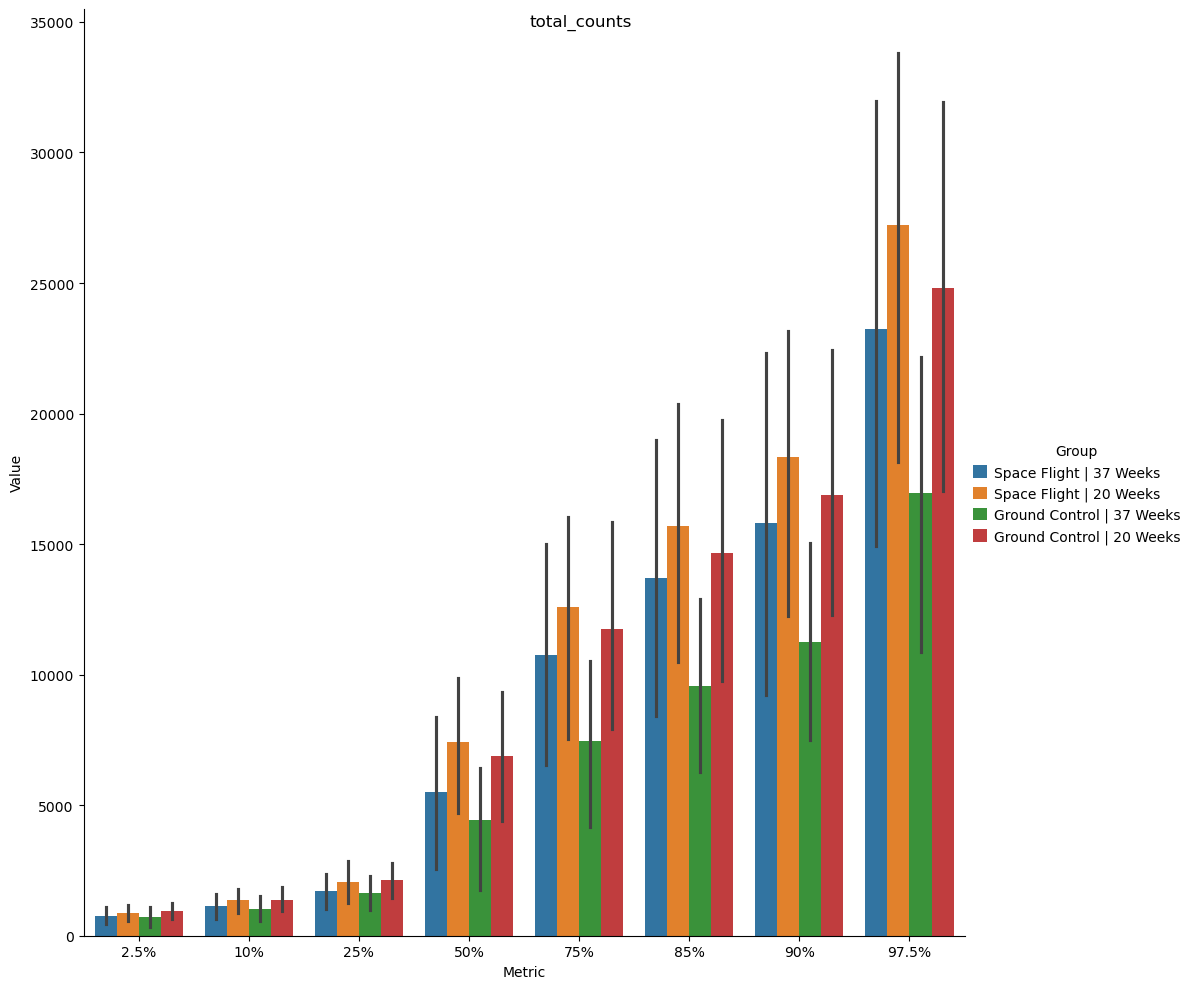

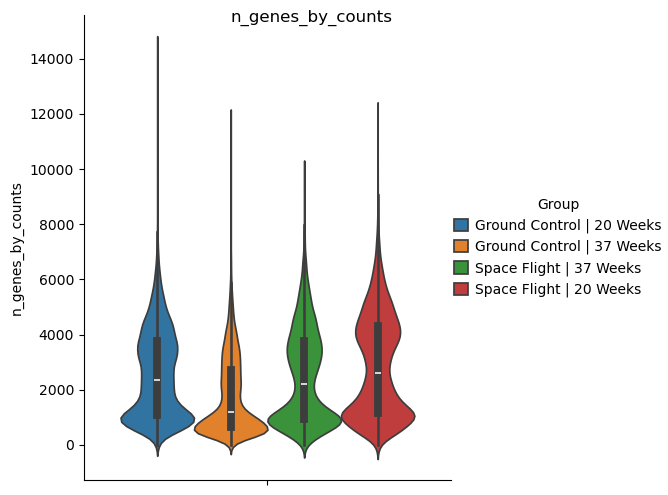

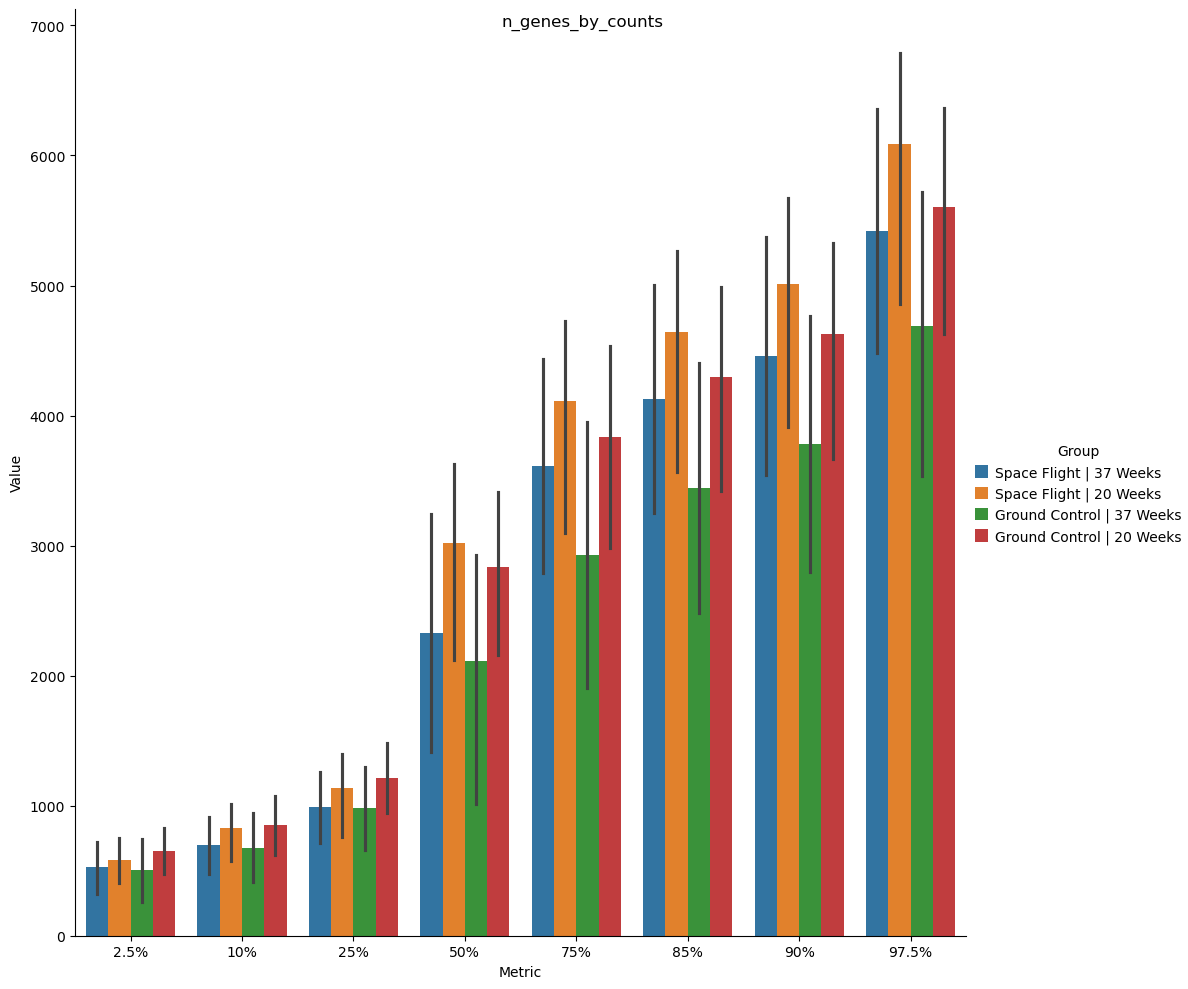

In [4]:
%matplotlib inline

plot_qc = False  # change to True to get sample-level QC plots (a bit slow)
qcs, n_cells_by_counts, descriptives, figs = scflow.pp.perform_qc_multi(
    adatas, col_batch=col_batch, col_sample=col_sample, plot=plot_qc,
    percentiles=[0.025, 0.10, 0.25, 0.50, 0.75, 0.85, 0.90, 0.975],
    figsize=(10, 10))  # perform QC on individual samples
for x in qcs:  # iterate QC metrics % plot percentiles by group
    fig = sns.catplot(qcs, y=x, hue=col_batch, kind="violin")
    fig.fig.suptitle(x)
    fig = sns.catplot(descriptives.loc[:, :, x][[
        i for i in descriptives if ("%" in i)]].stack().to_frame("Value"),
                      x="Metric", y="Value", kind="bar",
                      hue=col_batch, height=10)
    fig.fig.suptitle(x)
descriptives.stack().unstack("Variable").round()

## Auto-Detect Filtering Thresholds

Use 2.5th and/& 97.5th percentile (sample-specific) as minimum genes per cell and minimum and maximum total counts (subject to specified absolute minima). Use 97.5th percentile as upper bound for percent mitochondrial count. 

Use an absolute minimum cells per gene.

Also include arguments to run a PCA on individual samples before integrating.

In [5]:
# Options
bounds = descriptives[["2.5%", "97.5%"]].apply(lambda x: list(
    x), axis=1).unstack("Variable")  # list top/bottom 5% (~sample, variable)
abs_min_cells = 20  # regardless of %ile, minimum cells to retain gene
abs_min_genes = 200  # regardless of %ile, minimum genes to retain cell
abs_min_count = 300  # regardless of %ile, minimum counts to retain cell
abs_max_mt = 10  # regardless of %ile, absolute maximum mitochonrial content
n_top_genes = 2000  # number of top genes to count as HVGs

# Set Thresholds
kws_pp = {}
for x in adatas:
    b_x = bounds.loc[x]
    b_counts =  b_x["total_counts"] if isinstance(b_x[
            "total_counts"], list) else b_x["total_counts"].iloc[0]
    b_counts = [max(b_counts[0], abs_min_count), b_counts[1]]
    kws_pp[x] = {
        "min_max_genes": [max((b_x["n_genes_by_counts"] if isinstance(
            b_x["n_genes_by_counts"], list) else b_x[
                "n_genes_by_counts"].iloc[0])[0], abs_min_genes), None],
        "min_max_cells": [abs_min_cells, None],
        # "min_max_cells": [max((b_x["n_cells_by_counts"] if isinstance(
        #     b_x["n_genes_by_counts"], list) else b_x[
        #         "n_genes_by_counts"].iloc[0])[0], abs_min_cells), None],
        # "max_mt": min(abs_max_mt, (b_x["pct_counts_mt"] if isinstance(b_x[
        #     "pct_counts_mt"], list) else b_x["pct_counts_mt"].iloc[0])[1]),
        "max_mt": abs_max_mt,
        "min_max_counts": b_counts,
        # "vars_regress_out": ["total_counts"],
        "target_sum": 1e6,
        "zero_center": True, "max_value": 10,  # scaling
        "n_top_genes": n_top_genes,
        "doublet_detection": "drop"
    }
print("\n".join([f"{s}: {kws_pp[s]}" for s in kws_pp]))
pd.DataFrame(kws_pp).T

RRRM2_BRN_GC_ISS-T_YNG_GY4: {'min_max_genes': [321.0, None], 'min_max_cells': [20, None], 'max_mt': 10, 'min_max_counts': [414.0, 11122.175000000005], 'target_sum': 1000000.0, 'zero_center': True, 'max_value': 10, 'n_top_genes': 2000, 'doublet_detection': 'drop'}
RRRM2_BRN_GC_ISS-T_YNG_GY9: {'min_max_genes': [703.0, None], 'min_max_cells': [20, None], 'max_mt': 10, 'min_max_counts': [1006.1500000000001, 23784.40000000001], 'target_sum': 1000000.0, 'zero_center': True, 'max_value': 10, 'n_top_genes': 2000, 'doublet_detection': 'drop'}
RRRM2_BRN_GC_ISS-T_OLD_GO18: {'min_max_genes': [326.1, None], 'min_max_cells': [20, None], 'max_mt': 10, 'min_max_counts': [422.1, 13468.399999999998], 'target_sum': 1000000.0, 'zero_center': True, 'max_value': 10, 'n_top_genes': 2000, 'doublet_detection': 'drop'}
RRRM2_BRN_FLT_ISS-T_OLD_FO20: {'min_max_genes': [628.0, None], 'min_max_cells': [20, None], 'max_mt': 10, 'min_max_counts': [895.0, 19711.0], 'target_sum': 1000000.0, 'zero_center': True, 'max_va

min_max_genes min_max_cells max_mt                           min_max_counts target_sum zero_center max_value n_top_genes doublet_detection
RRRM2_BRN_GC_ISS-T_YNG_GY4                [321.0, None]    [20, None]     10              [414.0, 11122.175000000005]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_YNG_GY9                [703.0, None]    [20, None]     10  [1006.1500000000001, 23784.40000000001]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_OLD_GO18               [326.1, None]    [20, None]     10              [422.1, 13468.399999999998]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_OLD_FO20              [628.0, None]    [20, None]     10                         [895.0, 19711.0]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_OLD_GO19               [666.0, None]    [20, None]     10                         [942.0, 21190.0]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_OLD_GO13             [822.975, None]    [20, None]     10           [1282.925, 23156.550000000007]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_YNG_FY8             [481.425, None]    [20, None]     10              [681.7, 27907.149999999994]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_YNG_FY7             [331.925, None]    [20, None]     10            [452.77500000000003, 13453.3]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_OLD_FO19                [200, None]    [20, None]     10                [300, 14724.999999999998]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_YNG_GY7               [798.75, None]    [20, None]     10                     [1176.375, 28050.25]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_OLD_FO14            [719.475, None]    [20, None]     10              [1128.9, 33910.62499999997]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_YNG_GY1    [923.4000000000001, None]    [20, None]     10              [1489.7, 37456.77499999999]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_YNG_FY2               [700.2, None]    [20, None]     10                        [1087.2, 35338.0]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_OLD_FO17              [316.3, None]    [20, None]     10              [376.3, 11766.900000000009]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_OLD_GO16               [201.0, None]    [20, None]     10                [300, 10018.199999999983]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_OLD_FO16              [766.0, None]    [20, None]     10                       [1213.2, 36130.25]  1000000.0        True        10        2000              drop
RRRM2_BRN_GC_ISS-T_YNG_GY2                [507.0, None]    [20, None]     10             [696.45, 23662.899999999972]  1000000.0        True        10        2000              drop
RRRM2_BRN_FLT_ISS-T_YNG_FY5             [809.825, None]    [20, None]     10             [1300.3, 32231.825000000015]  1000000.0        True        10        2000              drop

# Integrate

## In-Memory Approach

See the "On-Disk Approach" for a more sophisticated approach to defining `kws_integrate` (more options).

In [6]:
# %%time

# # Integrate
# join_method = "outer"  # or "inner"
# kws_integrate = {"kws_pp": kws_pp, "n_top_genes": 10000,
#                  "fill_value": np.nan,
#                  "col_batch": None,  # suppress using batch as covariate
#                  "join": join_method, "merge": "unique", "use_rapids": True}
# self = scflow.Rna(adatas, col_sample=col_sample, col_batch=col_batch,
#                   kws_integrate=kws_integrate)
# self.rna.obs = self.rna.obs.assign(kws_integrate=str(kws_integrate))

# # Write Files for Processed/Integrated Objects?
# if overwrite is True or not os.path.exists(file_new):
#     os.makedirs("data", exist_ok=True)
#     self.rna.write_h5ad(file_new)
# for x in adatas:
#     pfp = os.path.join("data", f"{x}_processed.h5ad")
#     if overwrite is True or not os.path.exists(pfp):
#         adatas[x].write_h5ad(pfp)
# del adatas  # to save memory; now integrated in `self.rna`

# # Display
# print(self.rna)
# # print(self.rna.var.head())
# self.rna.obs

## On-Disk Approach

### Preprocess Individual

In [ ]:
# Preprocess
if overwrite is False and os.path.exists(pfp):
    raise ValueError("Must be able to overwrite to use on-disk option")
files_individual = dict(zip(files.keys(), [os.path.join(
    "data", f"{x}_processed.h5ad") for x in files]))  # new individual files
var_names = []  # to store genes not filtered out for each sample
for x in files:  # iterate sample files
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    adatas[x].obs.loc[:, f"kws_pp_{col_sample}"] = str(kws_pp[x])  # store kws
    adatas[x] = scflow.pp.preprocess(
        adatas[x], **kws_pp[x], plot_qc=False)  # preprocess data
    var_names += [set(adatas[x].var_names)]  # track what genes still present

# Decide Join Method
shared_genes = set.intersection(*var_names)  # genes in all after filtering
all_genes = set.union(*var_names)  # genes in any post-filter sample
print(f"{len(shared_genes)} genes present in all samples post-filtering (out"
      f" of {len(all_genes)} total genes present in any post-filter sample)")
join_method = "inner" if len(shared_genes) / len(all_genes) >= 0.5 else \
    "outer"  # outer join if <1/2 of genes shared across all samples



RRRM2_BRN_GC_ISS-T_YNG_GY4
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 8542 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Characteristics[Feeding Schedule]', 'Characteristics[Age at Euthanasia]', 'Unit.1', 'Term Source REF.7', 'Term Accession Number.7', 'Protocol REF', 'Parameter Value[habitat]', 'Parameter Value[Enrichment material]', 'Parameter Value[duration]', 'Unit.2', 'Term Source

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.15
Detected doublet rate = 5.9%
Estimated detectable doublet fraction = 60.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.8%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_YNG_GY9
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 6044 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Ch

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.19
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 55.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.2%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_OLD_GO18
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 6503 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.16
Detected doublet rate = 4.8%
Estimated detectable doublet fraction = 55.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.5%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_OLD_FO20
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 5641 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', '

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 2.8%
Estimated detectable doublet fraction = 54.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.2%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_OLD_GO19
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 8476 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.15
Detected doublet rate = 5.6%
Estimated detectable doublet fraction = 66.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.5%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_OLD_GO13
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 3880 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.22
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 52.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.0%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_YNG_FY8
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 5658 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 56.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.7%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_YNG_FY7
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 4238 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.14
Detected doublet rate = 5.8%
Estimated detectable doublet fraction = 59.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.7%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_OLD_FO19
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 7265 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', '

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 28.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.2%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_YNG_GY7
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 5776 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Ch

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 3.5%
Estimated detectable doublet fraction = 55.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.4%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_OLD_FO14
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 4260 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', '

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.22
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 47.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.8%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_YNG_GY1
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 3968 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Ch

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 43.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.9%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_YNG_FY2
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 4125 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 46.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.0%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_OLD_FO17
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 1493 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', '

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.20
Detected doublet rate = 2.9%
Estimated detectable doublet fraction = 30.6%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.4%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_OLD_GO16
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 20000 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', '

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 7.4%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 4.2%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_OLD_FO16
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 4863 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 2.3%
Estimated detectable doublet fraction = 43.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.3%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_GC_ISS-T_YNG_GY2
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 10779 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.17
Detected doublet rate = 5.1%
Estimated detectable doublet fraction = 50.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 9.9%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...


RRRM2_BRN_FLT_ISS-T_YNG_FY5
	***Activating layer 'counts'...
AnnData object with n_obs × n_vars = 4714 × 56748
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'C

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/cuml/internals/api_decorators.py:216: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ret = func(*args, **kwargs)


Automatically set threshold at doublet score = 0.18
Detected doublet rate = 3.1%
Estimated detectable doublet fraction = 54.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.7%
	***Normalizing...
	***Detecting highly variable genes...
	***Scaling data...
12209 genes present in all samples post-filtering (out of 23329 total genes present in any post-filter sample)


### Cluster Individual

#### Generalizable

In [8]:
# %%time

# # Clustering Parameter Options (Only Applied If `kws_cluster` != None)
# resolution_individual, min_dist_individual = 0.15, 1.5
# col_cluster_individual = "annotation_by_markers_individual"
# unlabeled_cat = "Heterogeneous"  # if can't find one best-fit cell label
# cci_scanvi = col_cluster_individual + "_heterogeneous_collapsed"
# sep = " | "  # separator for heterogeneous annotations

# # Preprocessing & (Optionally) Clustering
# if overwrite is False and os.path.exists(pfp):
#     raise ValueError("Must be able to overwrite to use on-disk option")
# # del adatas
# for x in files:  # iterate sample files
#     if kws_cluster is not None:  # cluster individual sample?
#         kws_cl = {"resolution": resolution_individual[x],
#                   "min_dist": min_dist_individual[x], **kws_cluster}
#         self.rna.obs.loc[:, "kws_cluster_individual"] = str(kws_cl)
#         adatas[x] = scflow.pp.cluster(
#             adatas[x], resolution=resolution_individual,
#             min_dist=min_dist_individual, plot=False,
#             col_celltype="leiden_individual", **kws_cl)  # cluster
#         sc.tl.rank_genes_groups(
#             adatas[x], "leiden_individual", n_genes=None, rankby_abs=False,
#             key_added="rank_genes_groups_leiden_individual",
#             copy=False)  # find markers/DEGs
#         if markers_predefined is not None:  # markers specified?
#             _, adatas[x] = scflow.pp.annotate_by_marker_overlap(
#                 adatas[x], markers_predefined,
#                 col_celltype="leiden_individual",
#                 col_celltype_new=col_cluster_individual, sep=sep,
#                 celltypes_superhierarchical=cts_superhierarchical,
#                 # top_n_markers=20,
#                 adj_pval_threshold=1e-10,
#                 method="overlap_coef", inplace=True)  # annotate by markers
#             if rename_marker_based_annotation is not None:
#                 adatas[x].obs.loc[:, col_cluster_individual] = adatas[
#                     x].obs[col_cluster_individual].replace(
#                         rename_marker_based_annotation)  # re-name
#             adatas[x].obs.loc[:, cci_scanvi] = adatas[x].obs[
#                 col_cluster_individual].apply(lambda x: unlabeled_cat if (
#                     sep in x) else x)  # re-label heterogeneous annotations
#     var_names += [set(adatas[x].var_names)]  # track what genes still there

# # Write Objects
# for x in adatas:
#     print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n{adatas[x]}\n")
#     adatas[x].write_h5ad(files_individual[x])  # write individual file

# # Plot
# if kws_cluster is not None:
#     for x in files:  # iterate sample files
#         ccs = [v for v in ["leiden_individual", col_cluster_individual
#                            ] if v in adatas[x].obs]  # columns for UMAP
#         print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
#         sc.pl.umap(adatas[x], color=ccs, wspace=0.4)  # plot UMAP
# del adatas  # save memory

#### OSD-613-Specific Tweaks

Iterate different clustering parameters to ensure extraction of common cell types

Make sample-specific alterations to one sample's annotation



RRRM2_BRN_GC_ISS-T_YNG_GY4
	***Calculating PCA with None components...
	***Building neighborhood...
	***Embedding UMAP with minimum distance 1...
	***Performing Leiden clustering with resolution 0.2...


2025-08-27 12:30:21 | [INFO] init


['Neuron', 'Oligodendrocyte', 'Microglial', 'OPC', 'Endothelial', 'Astrocyte', 'Neuron | Endothelial']
Categories (7, object): ['Neuron', 'Endothelial', 'OPC', 'Neuron | Endothelial', 'Oligodendrocyte', 'Astrocyte', 'Microglial']
	***Calculating PCA with None components...
	***Building neighborhood...
	***Embedding UMAP with minimum distance 0.75...
	***Performing Leiden clustering with resolution 0.2...
['Neuron', 'Oligodendrocyte', 'Microglial', 'OPC', 'Endothelial', 'Astrocyte', 'Neuron | Endothelial']
Categories (7, object): ['Neuron', 'Endothelial', 'OPC', 'Neuron | Endothelial', 'Oligodendrocyte', 'Microglial', 'Astrocyte']
	***Calculating PCA with None components...
	***Building neighborhood...
	***Embedding UMAP with minimum distance 0.5...
	***Performing Leiden clustering with resolution 0.2...
['Neuron', 'Oligodendrocyte', 'Microglial', 'OPC', 'Endothelial', 'Astrocyte', 'Neuron | Endothelial']
Categories (7, object): ['Neuron', 'Endothelial', 'Neuron | Endothelial', 'Oligode

/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:456: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:461: Perf

['Neuron', 'Oligodendrocyte', 'Microglial', 'Astrocyte', 'OPC', 'Endothelial']
Categories (6, object): ['Neuron', 'Astrocyte', 'Endothelial', 'Oligodendrocyte', 'Microglial', 'OPC']
{'resolution': 0.2, 'min_dist': 1}


RRRM2_BRN_FLT_ISS-T_OLD_FO14
	***Calculating PCA with None components...
	***Building neighborhood...
	***Embedding UMAP with minimum distance 1...
	***Performing Leiden clustering with resolution 0.2...
['Neuron', 'Astrocyte', 'OPC', 'Oligodendrocyte', 'Microglial', 'Endothelial']
Categories (6, object): ['Neuron', 'Microglial', 'Endothelial', 'Oligodendrocyte', 'Astrocyte', 'OPC']
{'resolution': 0.2, 'min_dist': 1}


RRRM2_BRN_GC_ISS-T_YNG_GY1
	***Calculating PCA with None components...
	***Building neighborhood...
	***Embedding UMAP with minimum distance 1...
	***Performing Leiden clustering with resolution 0.2...
['Oligodendrocyte', 'Neuron', 'Microglial', 'Astrocyte', 'OPC', 'Endothelial']
Categories (6, object): ['Neuron', 'Endothelial', 'Microglial', 'OPC', 'Oligo

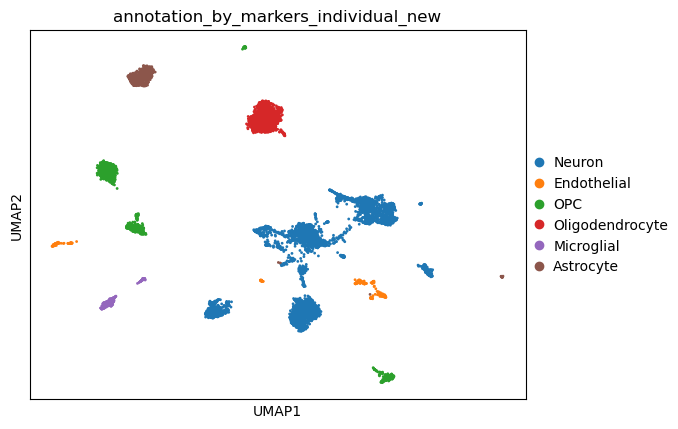



RRRM2_BRN_GC_ISS-T_YNG_GY4

AnnData object with n_obs × n_vars = 7547 × 19356
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Characteristics[Feeding Schedule]', 'Characteristics[Age at Euthanasia]', 'Unit.1', 'Term Source REF.7', 'Term Accession Number.7', 'Protocol REF', 'Parameter Value[habitat]', 'Parameter Value[Enrichment material]', 'Parameter Value[duration]', 'Unit.2', 'Term Source REF.8', 'Term Accession Number.

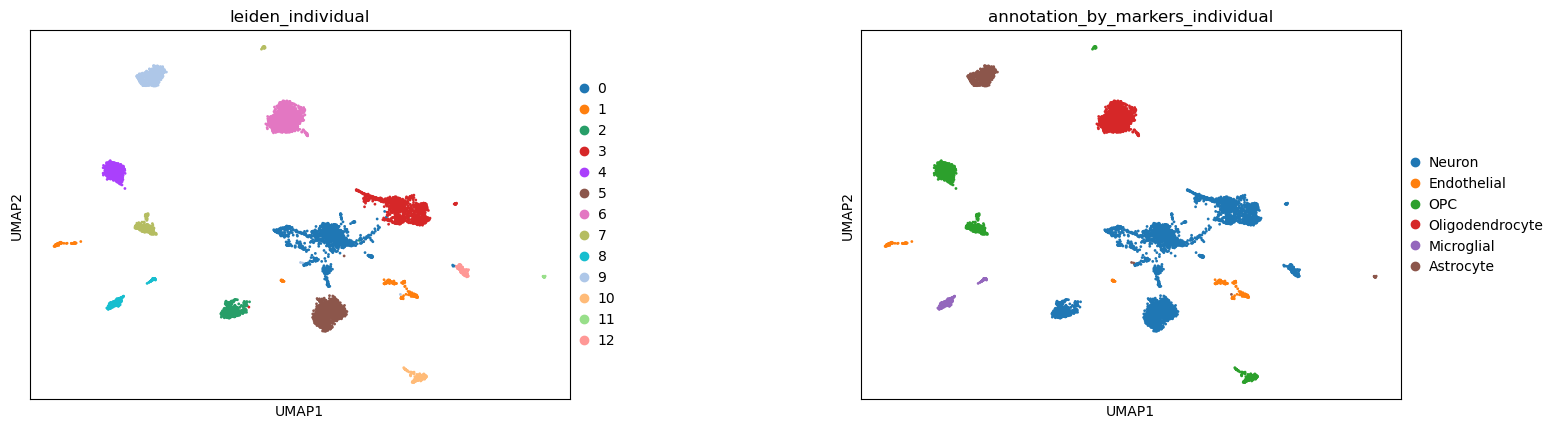

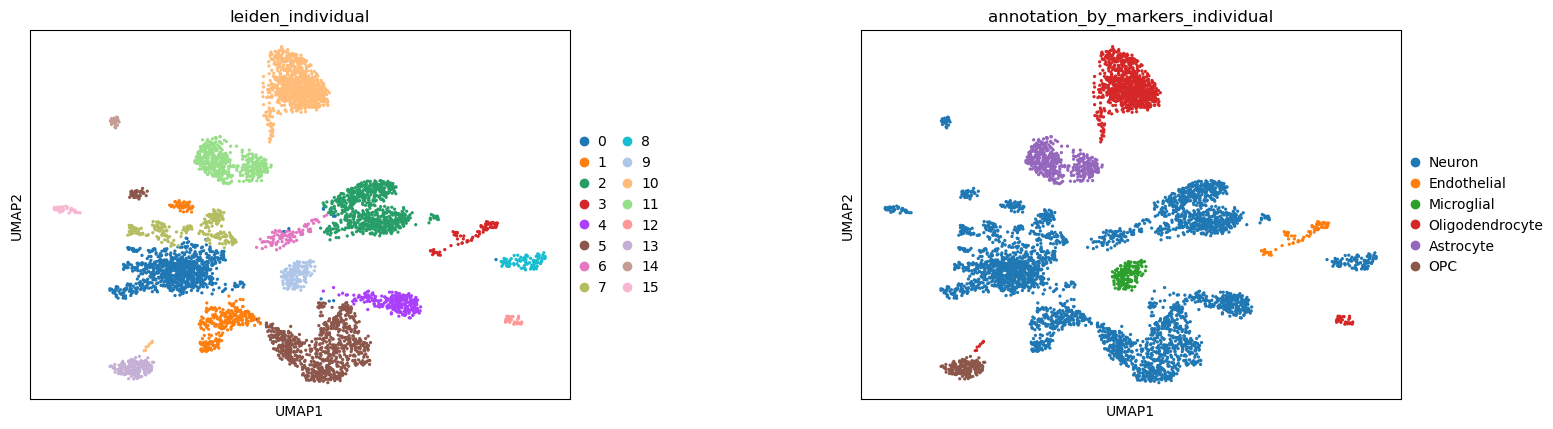

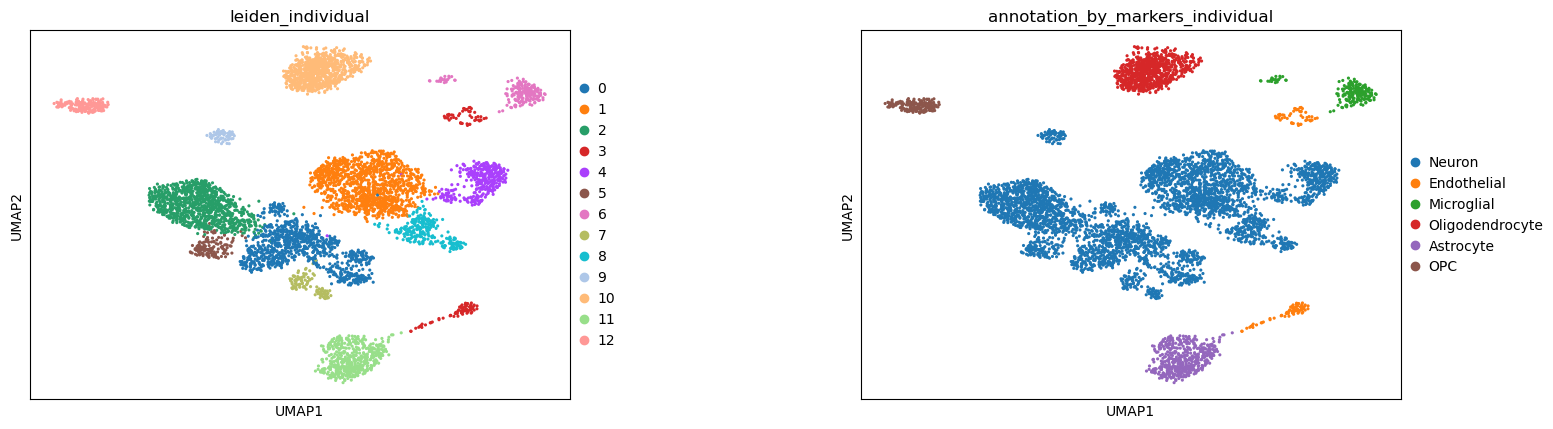

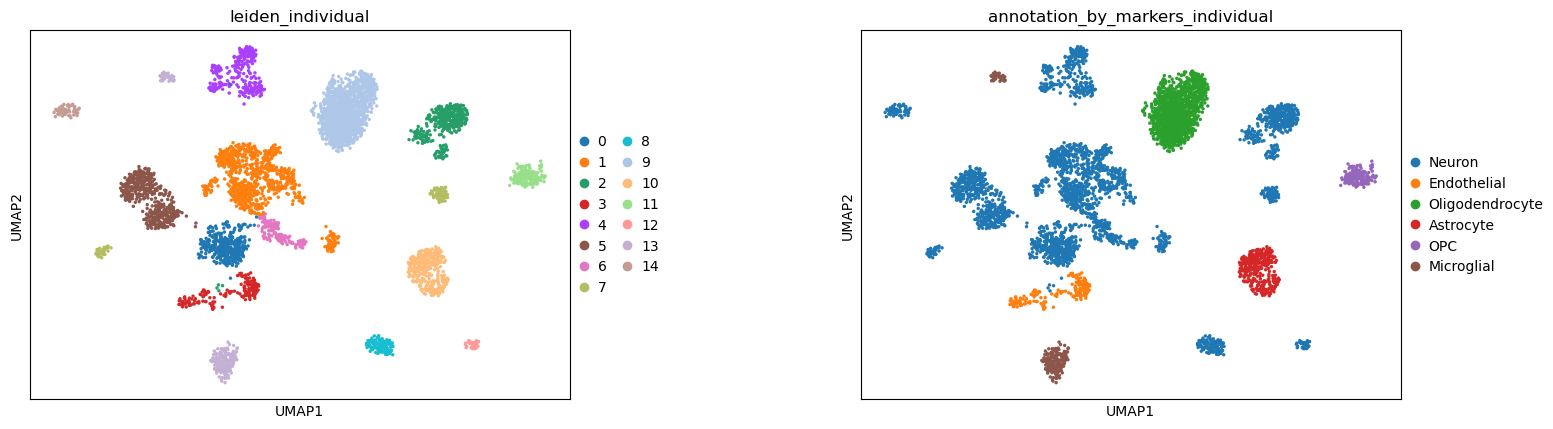

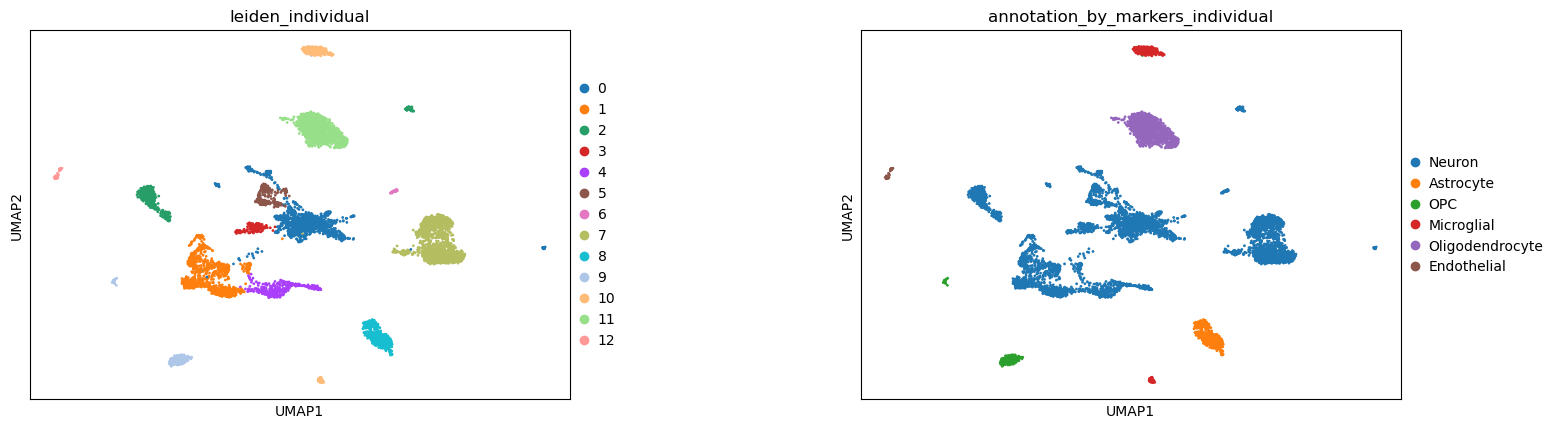

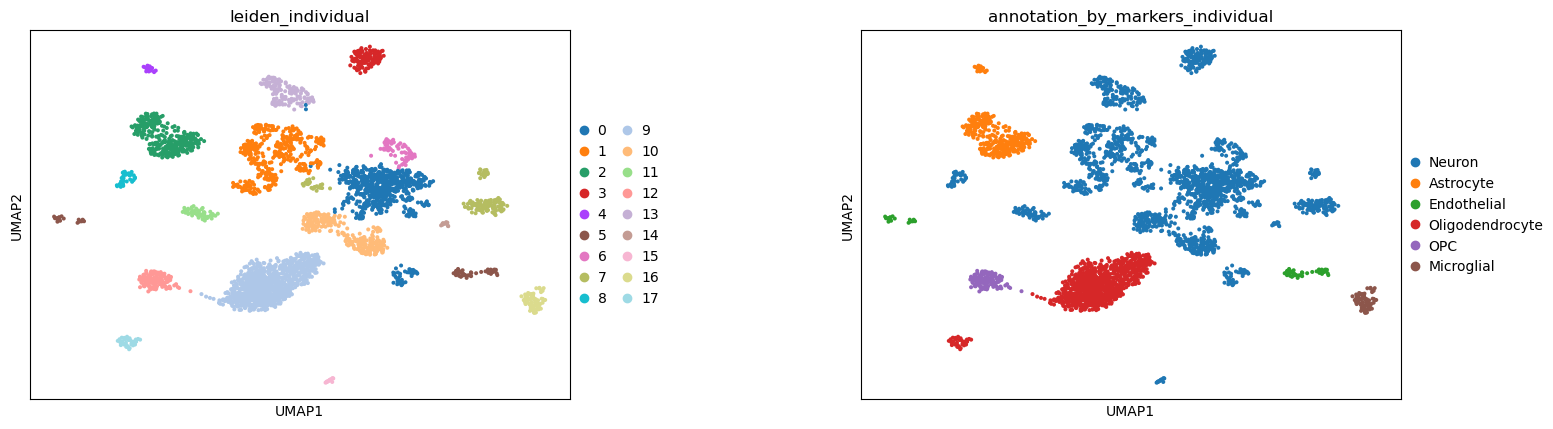

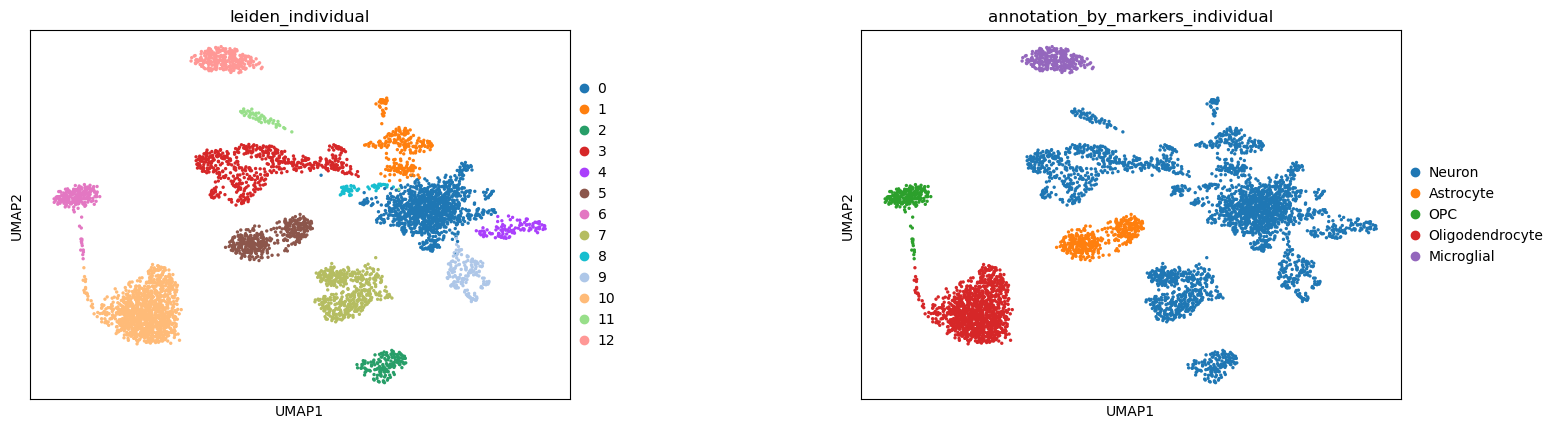

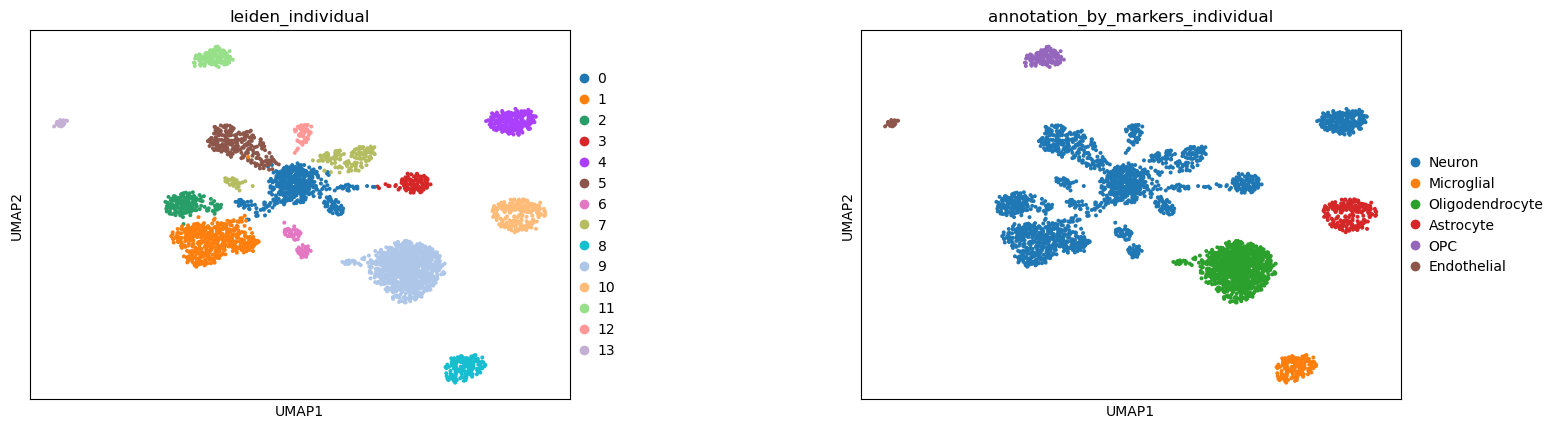

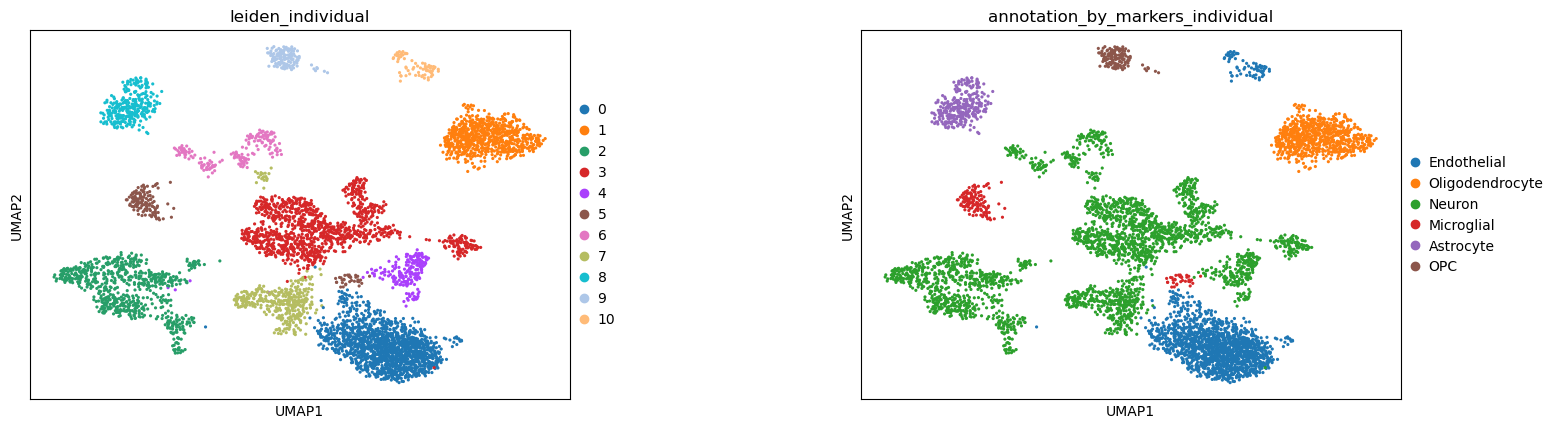

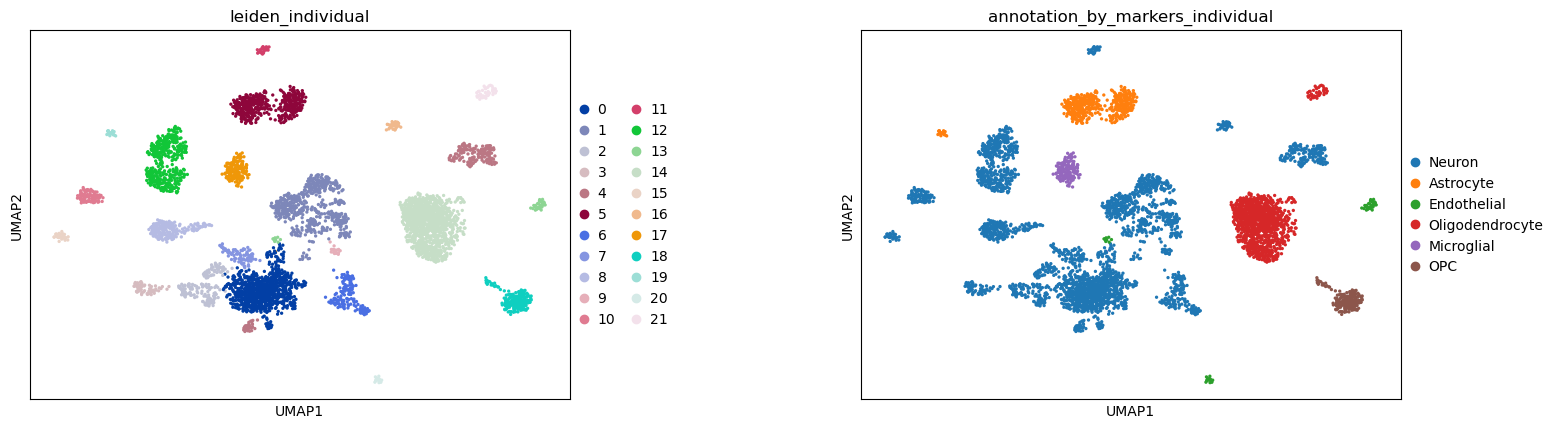

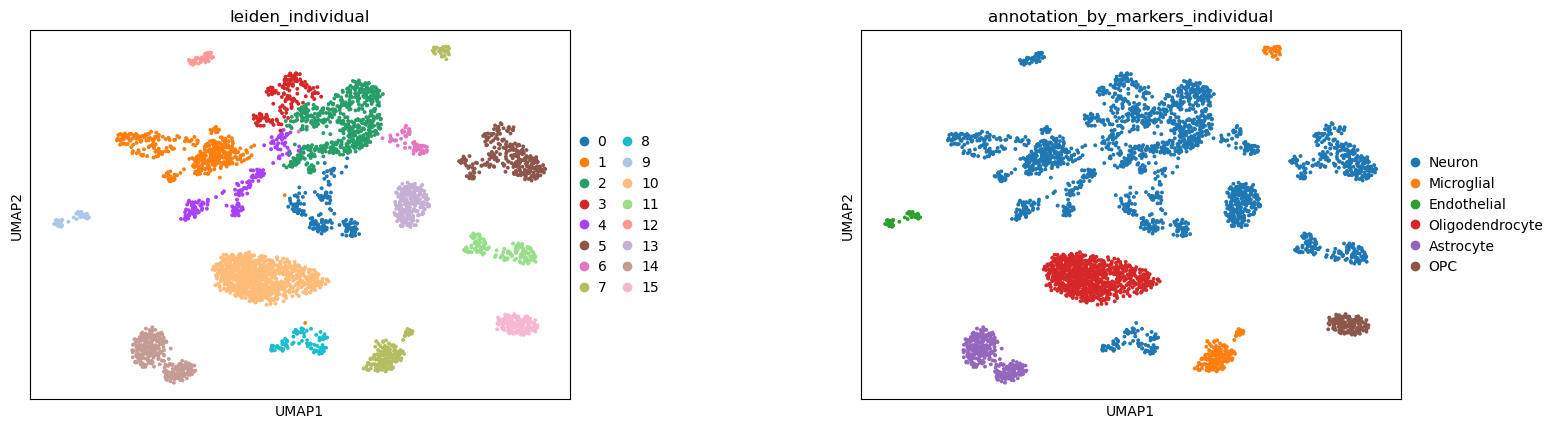

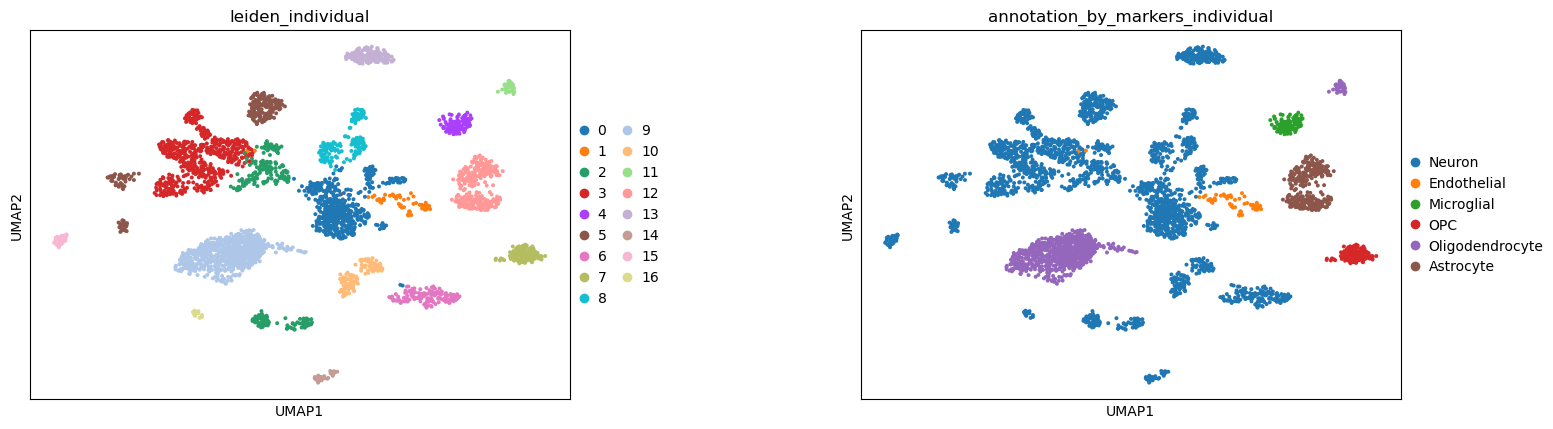

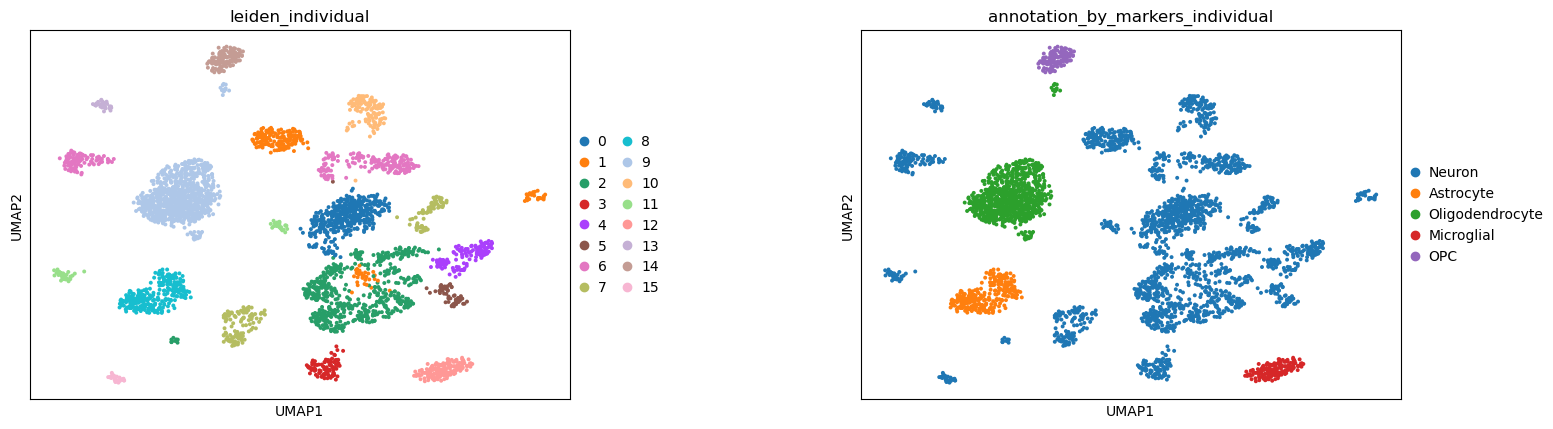

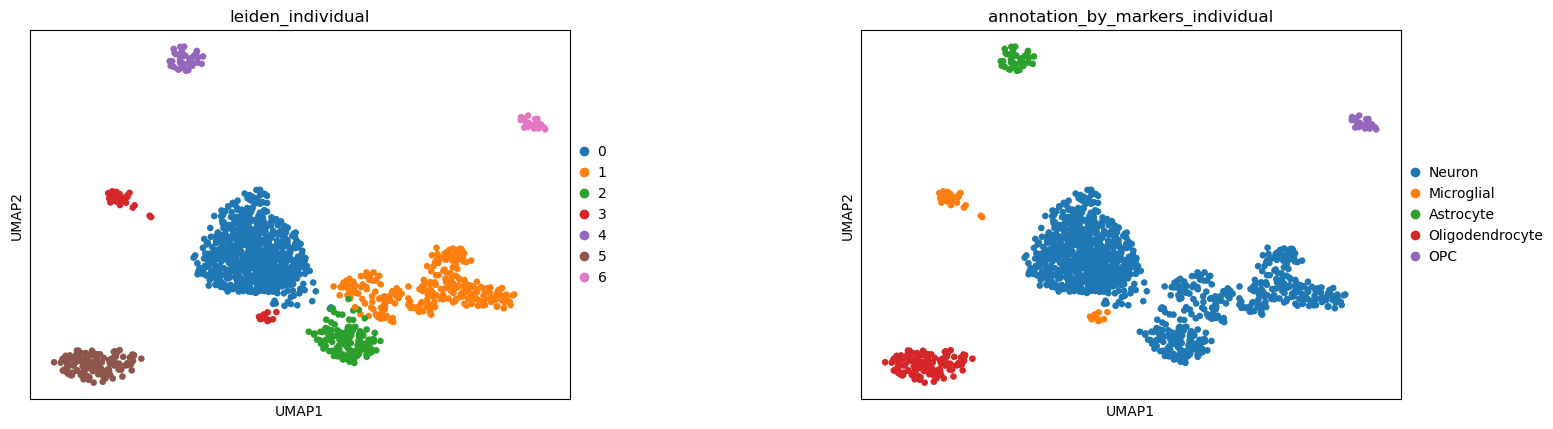

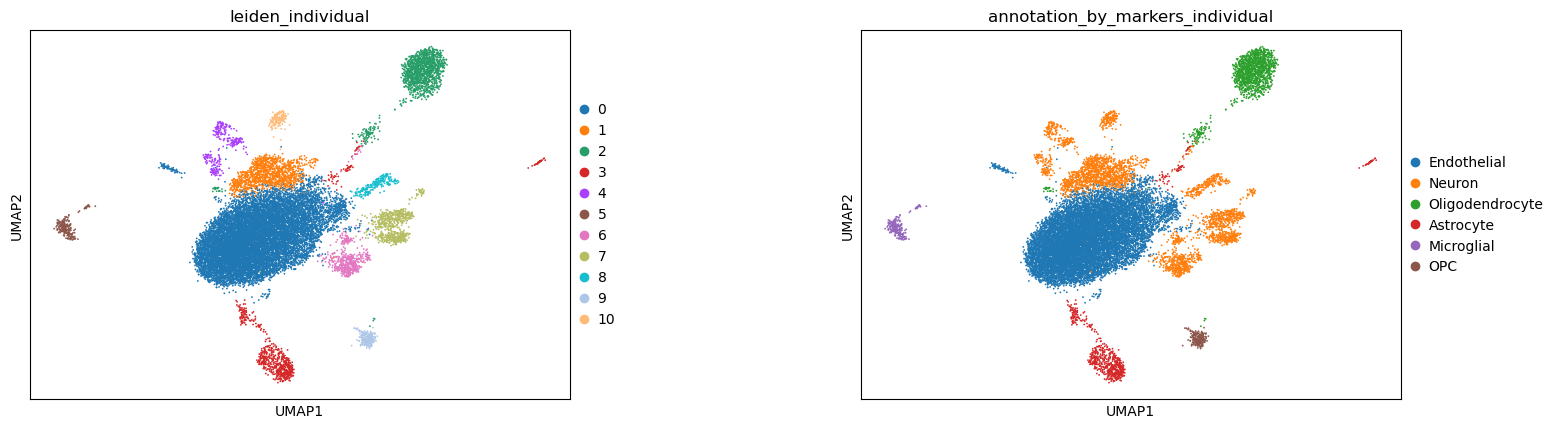

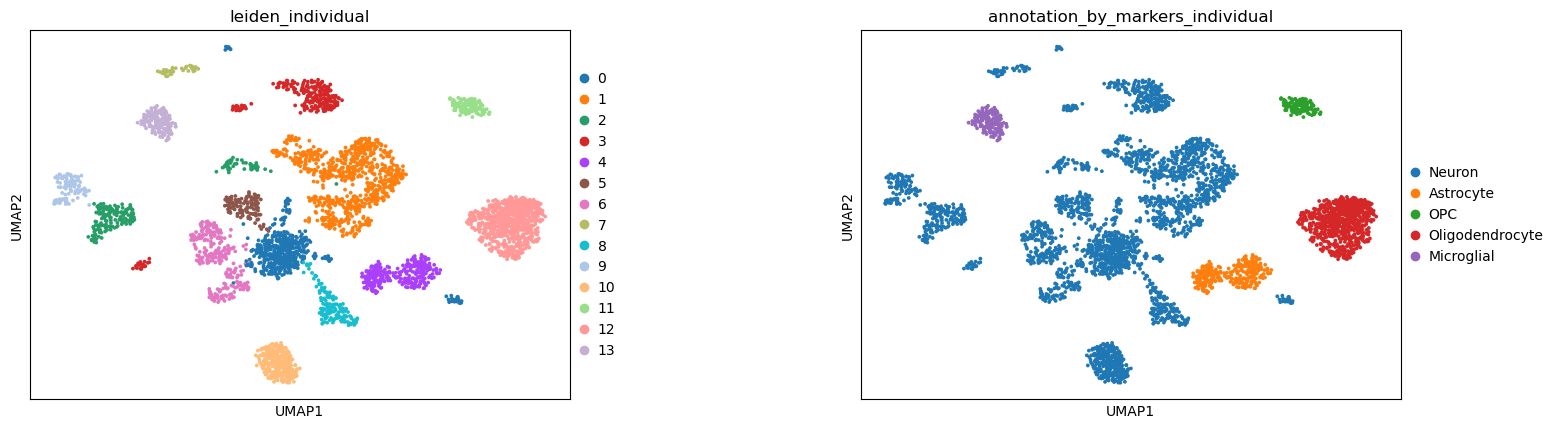

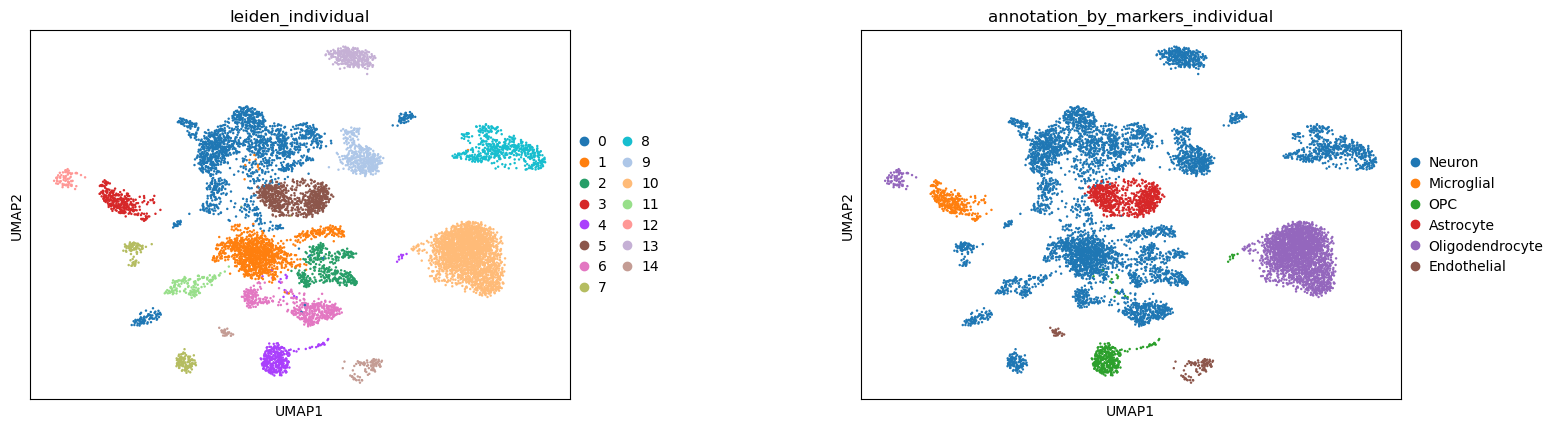

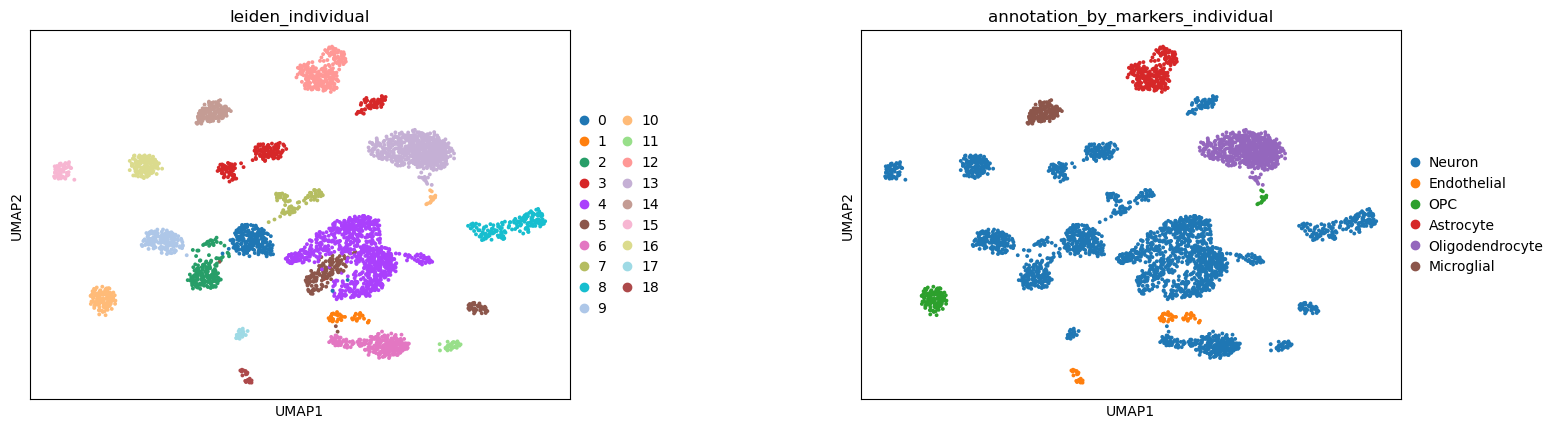

In [ ]:
# Clustering Parameter Options (Only Applied If `kws_cluster` != None)
req_cts = ["Neuron", "OPC", "Oligodendrocyte", "Astrocyte", "Microglial"]
prohib_cts = ["Excitatory-Inhibitory"]
resolution_individual, min_dist_individual = 0.2, 1.5
resn_list = [0.2, 0.5, 0.1, 0.075, 0.15]
dist_list = [1, 0.75, 0.5, 1.5, 0.3]
col_cluster_individual = "annotation_by_markers_individual"
unlabeled_cat = "Heterogeneous"  # if can't find one best-fit cell label
cci_scanvi = col_cluster_individual + "_heterogeneous_collapsed"
sep = " | "  # separator for heterogeneous annotations

# Clustering
for x in files:  # iterate sample files
    valid_cts = False
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    for r in resn_list:
        if valid_cts is True:
            break
        for t in dist_list:
            if valid_cts is True:
                break
            c_i = f"leiden_individual_res{r}dist{t}"
            cai = f"{col_cluster_individual}_res{r}dist{t}"
            kws_cl = {"resolution": r, "min_dist": t}
            adatas[x] = scflow.pp.cluster(
                adatas[x], plot=False, col_celltype=c_i, **kws_cl)
            sc.tl.rank_genes_groups(
                adatas[x], c_i, n_genes=None,
                key_added=f"rank_genes_groups_{c_i}",
                copy=False)  # find markers/DEGs
            _, adatas[x] = scflow.pp.annotate_by_marker_overlap(
                adatas[x], mks_collapsed,
                col_celltype=c_i, col_celltype_new=cai, sep=sep,
                celltypes_superhierarchical=cts_superhierarchical,
                # top_n_markers=20,
                adj_pval_threshold=1e-15,
                method="overlap_count", inplace=True)  # annotate
            if rename_marker_based_annotation is not None:
                adatas[x].obs.loc[:, cai] = adatas[x].obs[cai].replace(
                        rename_marker_based_annotation)  # re-name
            print(adatas[x].obs[cai].unique())
            adatas[x].obs.loc[:, cci_scanvi] = adatas[x].obs[
                cai].apply(lambda x: unlabeled_cat if (sep in x) else x)
            valid_cts = all([q in adatas[x].obs[cai].unique()
                             for q in req_cts])
            valid_cts = valid_cts and (all([q not in adatas[x].obs[
                cai].unique() for q in prohib_cts]))
            valid_cts = False if any(adatas[x].obs[
                cci_scanvi] == unlabeled_cat) else valid_cts
            if valid_cts is True:
                adatas[x].obs.loc[:, "leiden_individual"] = adatas[x].obs[c_i]
                adatas[x].obs.loc[:, col_cluster_individual] = adatas[
                    x].obs[cai]
                adatas[x].obs.loc[:, "kws_cluster_individual"] = str(kws_cl)
                print(kws_cl)

# Detect Samples with No Valid Clustering Scheme
no_valid = []
for x in files:
    if all((i in adatas[x].obs for i in [
            "leiden_individual", col_cluster_individual])) is False:
        print(f"No valid clustering found for {x}")
        no_valid += [x]
print(f"No Valid: {no_valid}")

# Individual Tweak
samp = "RRRM2_BRN_GC_ISS-T_YNG_GY4"
cols_tries = [i for i in adatas[samp].obs if "leiden_" in i]
cts_try = cols_tries[14]
_, adatas[samp] = scflow.pp.annotate_by_marker_overlap(
    adatas[samp], mks_collapsed, col_celltype=cts_try,
    col_celltype_new=col_cluster_individual + "_new", sep=sep,
    adj_pval_threshold=1e-5,
    method="overlap_coef", inplace=True)  # annotate by markers
adatas[samp].obs.loc[:, "leiden_individual"] = adatas[samp].obs[cts_try]
adatas[samp].obs.loc[:, col_cluster_individual] = adatas[samp].obs[
    col_cluster_individual + "_new"]
adatas[samp].obs["kws_cluster_individual"] = str({"resolution": float(
    cts_try.split("res")[1].split("dist")[0]), "min_dist": float(
        cts_try.split("res")[1].split("dist")[1])})

# Write Objects
for x in adatas:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n{adatas[x]}\n")
    adatas[x].write_h5ad(files_individual[x])  # write individual file

# Print Parameters Used
for x in adatas:
    print(adatas[x].obs["kws_cluster_individual"])

# Plot
for x in adatas:
    sc.pl.umap(adatas[x], color=[
        "leiden_individual", col_cluster_individual], wspace=0.4)
del adatas

### Concatenate & Integrate

If you are concerned about hard drive space, you may want to delete `file_concat` and `files_individual` after running this cell.


>>>Concatenating data...

>>>Finding HVGs for overall data...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



>>>Integrating with respect to sample (SCANVI)...
	***Using counts layer for scanvi...

>>>Integrating with respect to sample (SCANVI)...
	***Setting up scVI model: {'n_latent': 40, 'n_hidden': 400}...
	***Traning scVI: {'max_epochs': 100, 'accelerator': 'gpu', 'batch_size': 1024, 'early_stopping': True}...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


	***Setting up scANVI model: {'n_latent': 40, 'n_hidden': 400}...
	***Traning scANVI: {'max_epochs': 100, 'accelerator': 'gpu', 'batch_size': 1024, 'early_stopping': True}...
INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


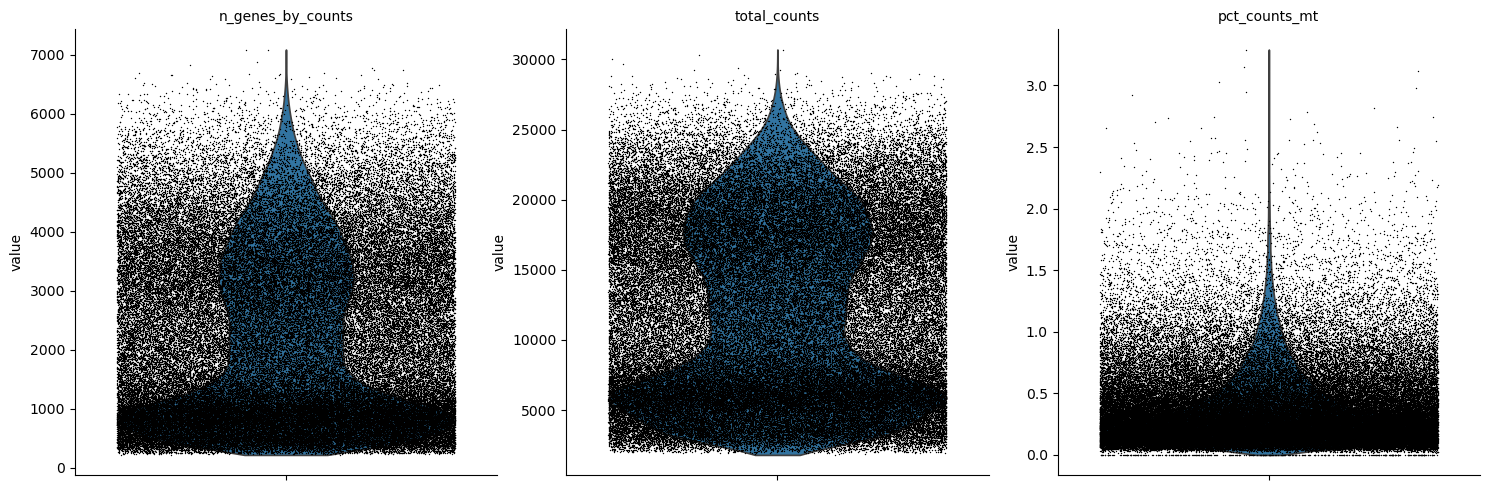

count     12209.000000
mean      18390.727742
std       15953.886715
min         553.000000
25%        6592.000000
50%       12862.000000
75%       25092.000000
max      103242.000000
Name: n_cells_by_counts, dtype: float64


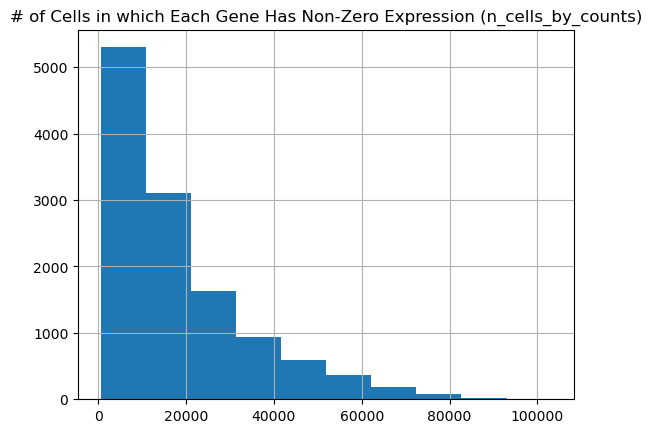

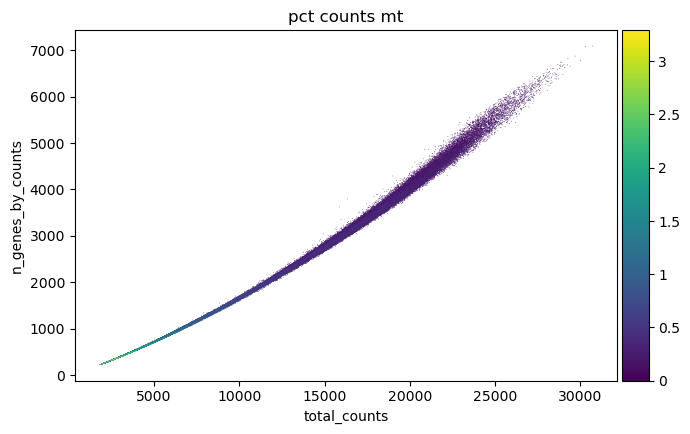

AnnData object with n_obs × n_vars = 103274 × 12209
    obs: 'Group', 'sample', 'Characteristics[Organism]', 'Term Source REF', 'Term Accession Number', 'Characteristics[Strain]', 'Term Source REF.1', 'Term Accession Number.1', 'Characteristics[Genotype]', 'Term Source REF.2', 'Term Accession Number.2', 'Characteristics[Animal Source]', 'Characteristics[Sex]', 'Term Source REF.3', 'Term Accession Number.3', 'Factor Value[Spaceflight]', 'Term Source REF.4', 'Term Accession Number.4', 'Factor Value[Age]', 'Unit', 'Term Source REF.5', 'Term Accession Number.5', 'Characteristics[Material Type]', 'Term Source REF.6', 'Term Accession Number.6', 'Characteristics[diet]', 'Characteristics[Feeding Schedule]', 'Characteristics[Age at Euthanasia]', 'Unit.1', 'Term Source REF.7', 'Term Accession Number.7', 'Protocol REF', 'Parameter Value[habitat]', 'Parameter Value[Enrichment material]', 'Parameter Value[duration]', 'Unit.2', 'Term Source REF.8', 'Term Accession Number.8', 'Parameter Value[light c

Group                       sample Characteristics[Organism] Term Source REF                              Term Accession Number  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
AAACAGCCAGCACCAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
AAACAGCCAGGTTCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
AAACAGCCATCAATCG-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
AAACAGCCATGTCAAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4   Ground Control | 20 Weeks   RRRM2_BRN_GC_ISS-T_YNG_GY4              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
...                                                                   ...                          ...                       ...             ...                                                ...   
TTTGTGTTCCCTGATC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
TTTGTGTTCCGTAAAC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
TTTGTGTTCTGTGCAG-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
TTTGTTGGTGTTAGCA-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   
TTTGTTGGTTAAGTGT-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5    Space Flight | 20 Weeks  RRRM2_BRN_FLT_ISS-T_YNG_FY5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...   

                                               Characteristics[Strain] Term Source REF.1               Term Accession Number.1 Characteristics[Genotype] Term Source REF.2  \
AAACAGCCAATCGCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4              C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
AAACAGCCAGCACCAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4              C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
AAACAGCCAGGTTCAC-1_RRRM2_BRN_GC_ISS-T_YNG_GY4              C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
AAACAGCCATCAATCG-1_RRRM2_BRN_GC_ISS-T_YNG_GY4              C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
AAACAGCCATGTCAAT-1_RRRM2_BRN_GC_ISS-T_YNG_GY4              C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
...                                                                ...               ...                                   ...                       ...               ...   
TTTGTGTTCCCTGATC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
TTTGTGTTCCGTAAAC-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5             C57BL/6NTac               EFO  http://www.ebi.ac.uk/efo/EFO_0020093                 Wild Type              NCIT   
TTTGTGTTCTGTGCAG-1_RRRM2_BRN_FLT_ISS-T_YNG_FY5             C57BL/6NTac               EFO  http://www.ebi.ac.uk/ef

In [10]:
%%time

# Integration Options
cct_available = kws_cluster is not None and (
    markers_predefined is not None)  # individual annotations available?
kws_vi = {"early_stopping": True,
          "batch_size": 1024,  # raise/lower if more/less than 16 GB VRAM
          "max_epochs": 100,
          "accelerator": "gpu",
          # "categorical_covariate_keys": covariates_categorical,
          "n_latent": 40, "n_hidden": 400}  # scVI/scANVI arguments
kws_integrate = {
    "col_celltype": cci_scanvi if cct_available else None,
    "flavor": "scanvi",
    # "flavor": "scvi",
    # "flavor": "scanorama",
    # "flavor": "harmony",
    "kws_pp": None, "kws_cluster": None,
    # "n_top_genes": 5000,
    "n_top_genes": None,
    "join": join_method, "merge": "same",
    "col_batch": None,  # suppress using batch as covariate
    "drop_non_hvgs": False,
    "use_rapids": True,
    "fill_value": np.nan if join_method == "outer" else None,
    "out_file": file_concat, **kws_vi
}

# If scVI/scANVI Integration & Individual Annotations Available
if kws_integrate["flavor"] in ["scvi", "scanvi"] and cct_available is True:
    kws_integrate.update({"unlabeled_category": unlabeled_cat})

# Integrate & Store Integration Parameters in Object
self = scflow.Rna(files_individual, col_sample=col_sample,
                  col_batch=col_batch, kws_integrate=kws_integrate)
self.rna.obs = self.rna.obs.assign(kws_integrate=str(kws_integrate))

# Write Files for Processed/Integrated Objects?
if overwrite is True or not os.path.exists(file_new):
    self.rna.write_h5ad(file_new)

# Display
print(self.rna)
self.rna.obs

## Benchmark Integration

In [11]:
# if kws_integrate["flavor"] == "scanvi":
#     try:
#         results_integration_benchmark = scflow.pp.benchmark_integration(
#             self.rna, col_sample, col_celltype="annotation_scanvi")
#     except Exception as err:
#         print(err)

# Clustering

Perform PCA, UMAP embedding, and Leiden clustering on the integrated object

	***Building neighborhood with 40 neighbors...
	***Embedding UMAP with minimum distance 1...
	***Performing Leiden clustering with resolution 0.025...
        n_cells
leiden         
0         21527
1         19639
5         19269
2         18451
6          8753
4          7160
8          3200
7          3117
3          2158
leiden                            0     1     2     3    4     5     6    7    8
sample                                                                          
RRRM2_BRN_GC_ISS-T_YNG_GY4      610  1491  1219  1237  552  1071   946  190  231
RRRM2_BRN_GC_ISS-T_YNG_GY9      420  1394   908    69  493  1066   731  197  187
RRRM2_BRN_GC_ISS-T_OLD_GO18     490  1114   801    44  559  1432  1039  177  186
RRRM2_BRN_FLT_ISS-T_OLD_FO20    445   833  1242    60  347  1141   500  173  181
RRRM2_BRN_GC_ISS-T_OLD_GO19     591  1619  1365    68  522  1404  1447  255  268
RRRM2_BRN_GC_ISS-T_OLD_GO13     213   960   989    74  341   531   267  132   88
RRRM2_BRN_FLT_ISS-T_YNG_F

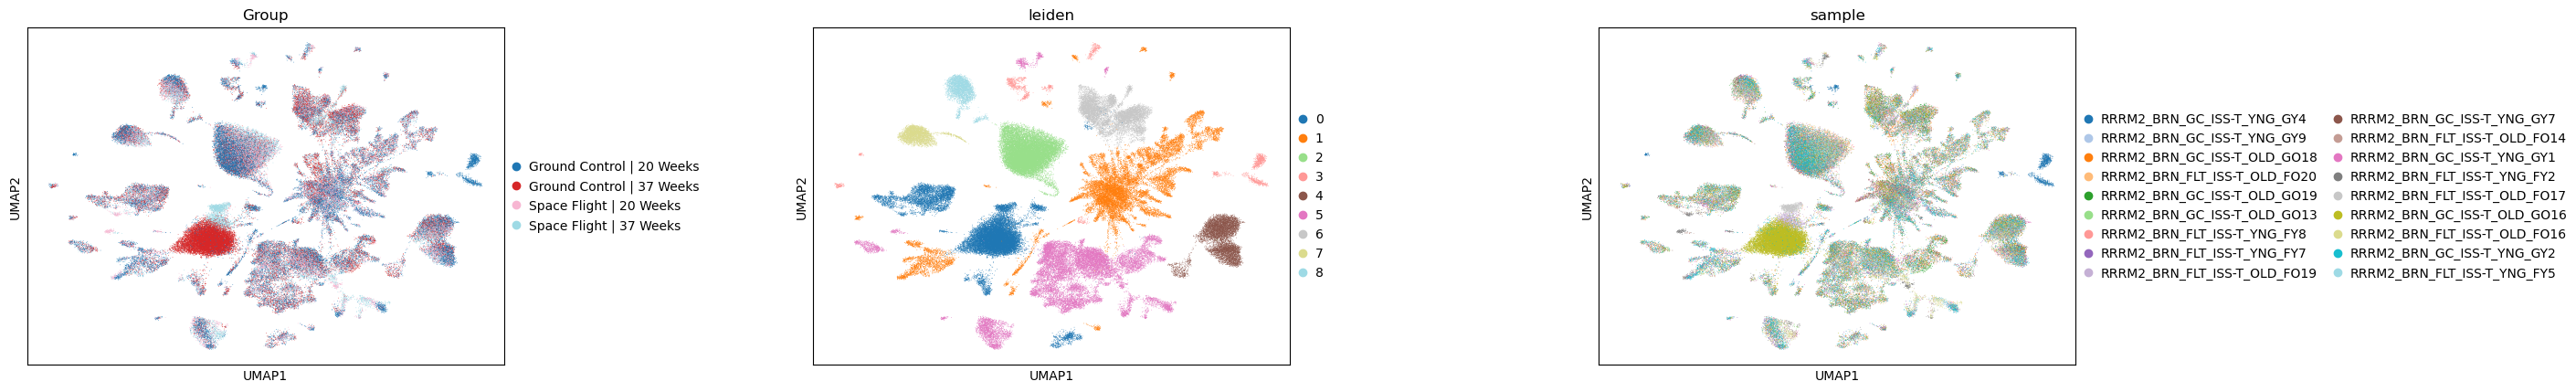

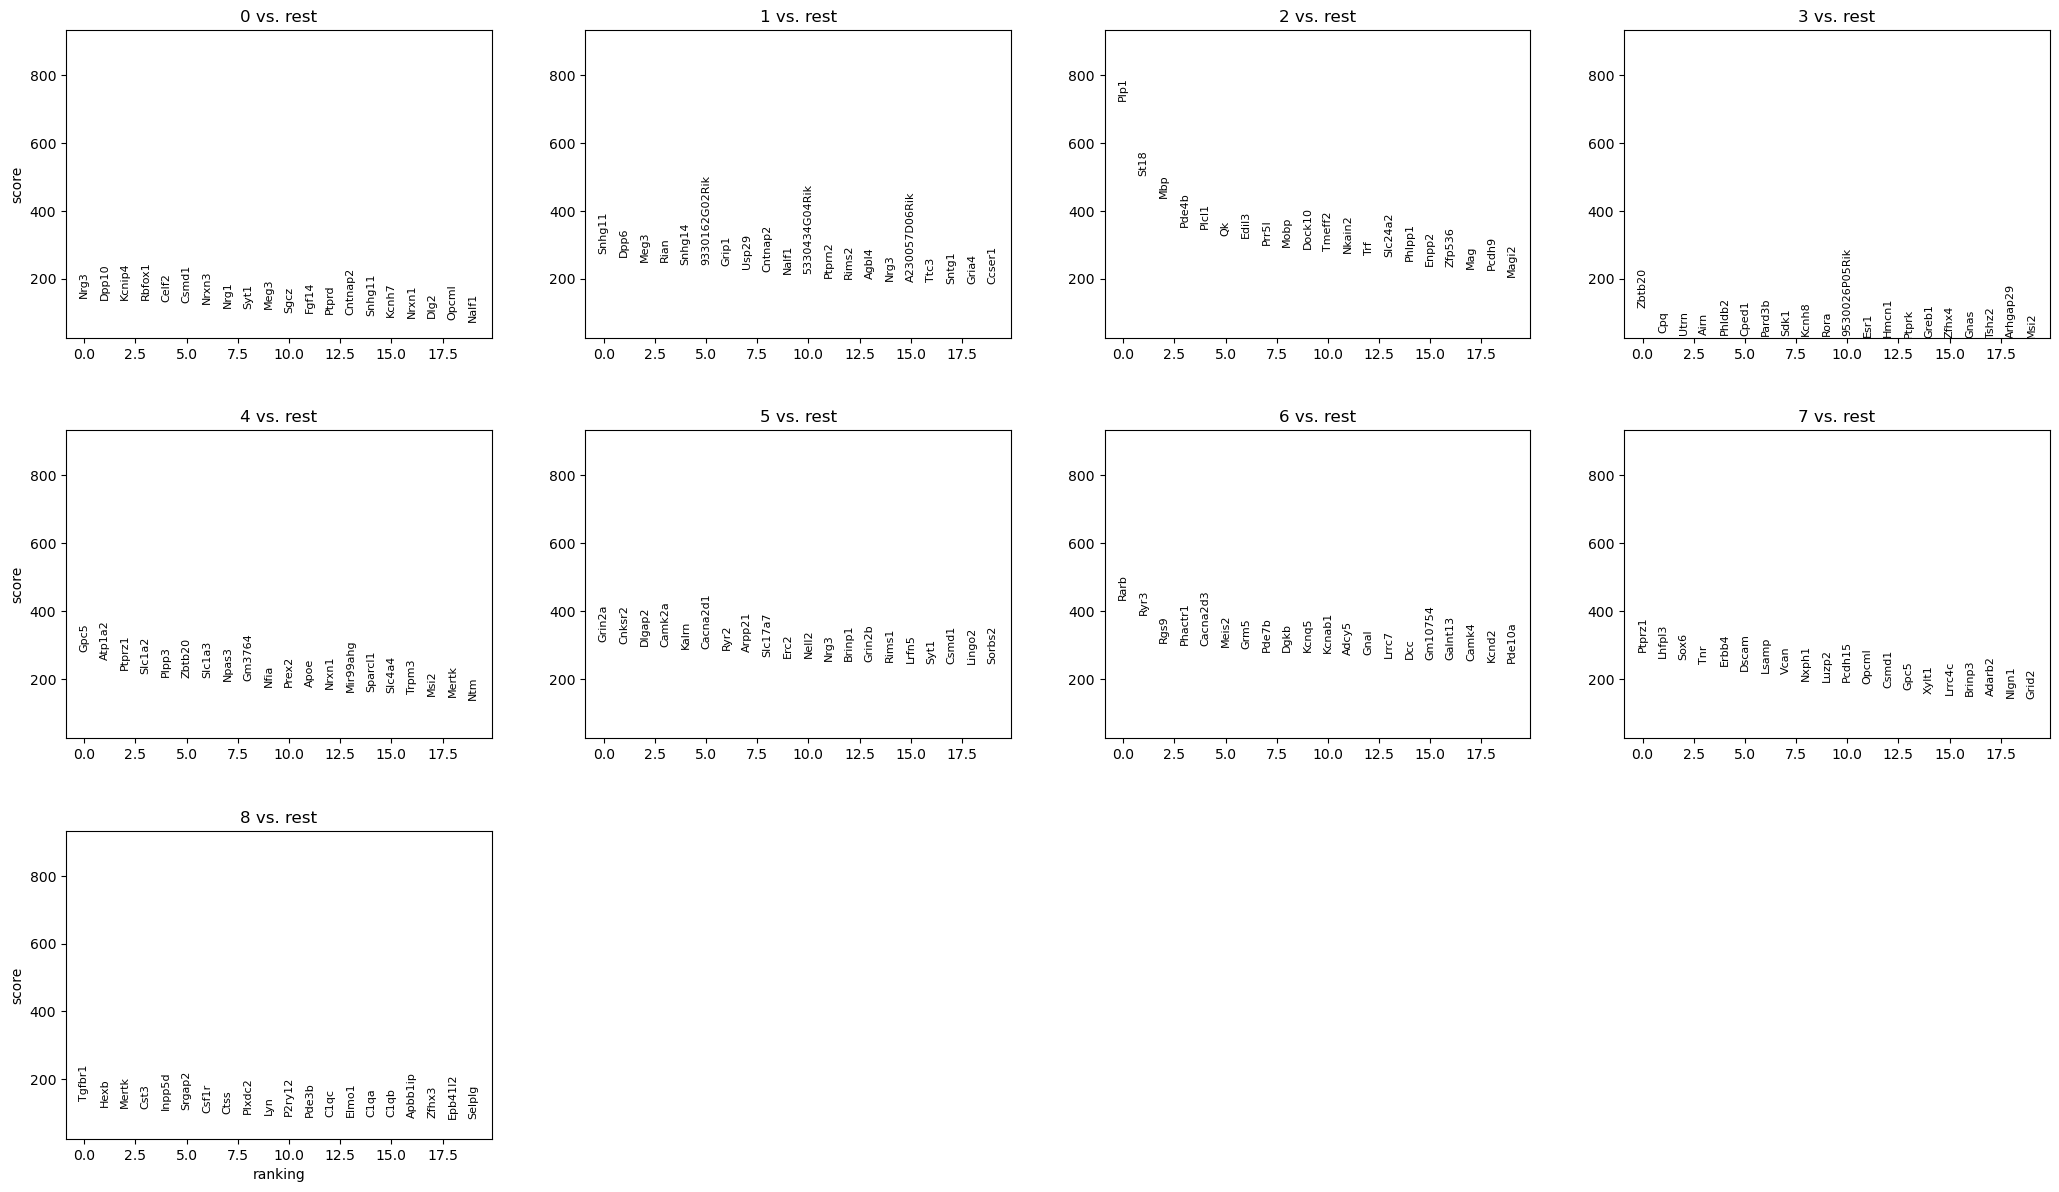

CPU times: user 25.5 s, sys: 2.28 s, total: 27.8 s
Wall time: 10.5 s


In [21]:
%%time


# Clustering Options
resolution, min_dist = 0.025, 1
# resolution, min_dist = 0.027, 1.3
# resolution, min_dist = 0.012, 1.5
# resolution, min_dist = 0.027, 1.3
# resolution, min_dist = 0.035, 1.3
# resolution, min_dist = 0.02, 0.6
# resolution, min_dist = 0.018, 0.7
# resolution, min_dist = 0.012, 0.5
# resolution, min_dist = 0.0115, 1.5
# resolution, min_dist = 0.011, 0.5
n_neighbors = 40
cct = "leiden"  # key added/column name

# Clustering
self.cluster(col_celltype=cct, resolution=resolution, min_dist=min_dist,
             kws_pca=False, layer="scaled",
             kws_neighbors=dict(n_neighbors=n_neighbors))  # cluster
self.rna.obs = self.rna.obs.assign(**{
       f"{cct}_resolution": resolution}).assign(
              **{f"{cct}_n_neighbors": n_neighbors}).assign(
                     **{f"{cct}_min_dist": min_dist})  # store parameters
_ = self.plot(kind="umap", wspace=0.5, palette="tab20",
              color=[col_batch, "leiden", col_sample])  # plot UMAP
print(self.rna.obs["leiden"].value_counts().to_frame("n_cells"))  # N/cluster
print(self.rna.obs.groupby(col_sample).apply(lambda x: x[
       cct].value_counts(), include_groups=False).unstack(1))  # by group
self.find_markers(col_celltype=cct)  # DEGs by cluster
col_celltype = "leiden"
self._info["col_celltype"] = col_celltype

# Sub-Clustering

Sub-cluster the biggest <subcluster_biggest> Leiden clusters?

For instance if `subcluster_biggest = 3`, take top three most abundant (highest cell count) clusters and sub-cluster them.

In [22]:
resolution_sub = None if subcluster_biggest is False else 0.005
if subcluster_biggest is not False:
    col_celltype = "leiden_subcluster"
    biggest_clusters = self.rna.obs["leiden"].value_counts().index.values[
        :min(len(self.rna.obs["leiden"].unique()), subcluster_biggest)]
    self.rna.obs.loc[:, col_celltype] = self.rna.obs.leiden.copy()
    for x in biggest_clusters:
        sc.tl.leiden(self.rna, restrict_to=(col_celltype, [x]),
                     key_added=col_celltype, resolution=resolution_sub,
                     seed=0, n_iterations=-1, use_weights=True)
    self.find_markers(col_celltype=col_celltype)  # DEGs by cluster
    self.plot(kind="umap", color=col_celltype)
    print(self.rna.obs[[col_sample, col_celltype]].groupby(
        col_sample).value_counts().unstack(1))
    self.rna.obs.loc[:, f"resolution_{col_celltype}"] = resolution_sub
    self._info["col_celltype"] = col_celltype

# Annotate

Annotate cell types with various methods

## Examine Marker Genes

This code looks at top markers by log2fold-change and adjusted p-value cutoffs and sorts by adjusted p-values.

Use `kind = ["heat", "dot"]` to get dot plots too.

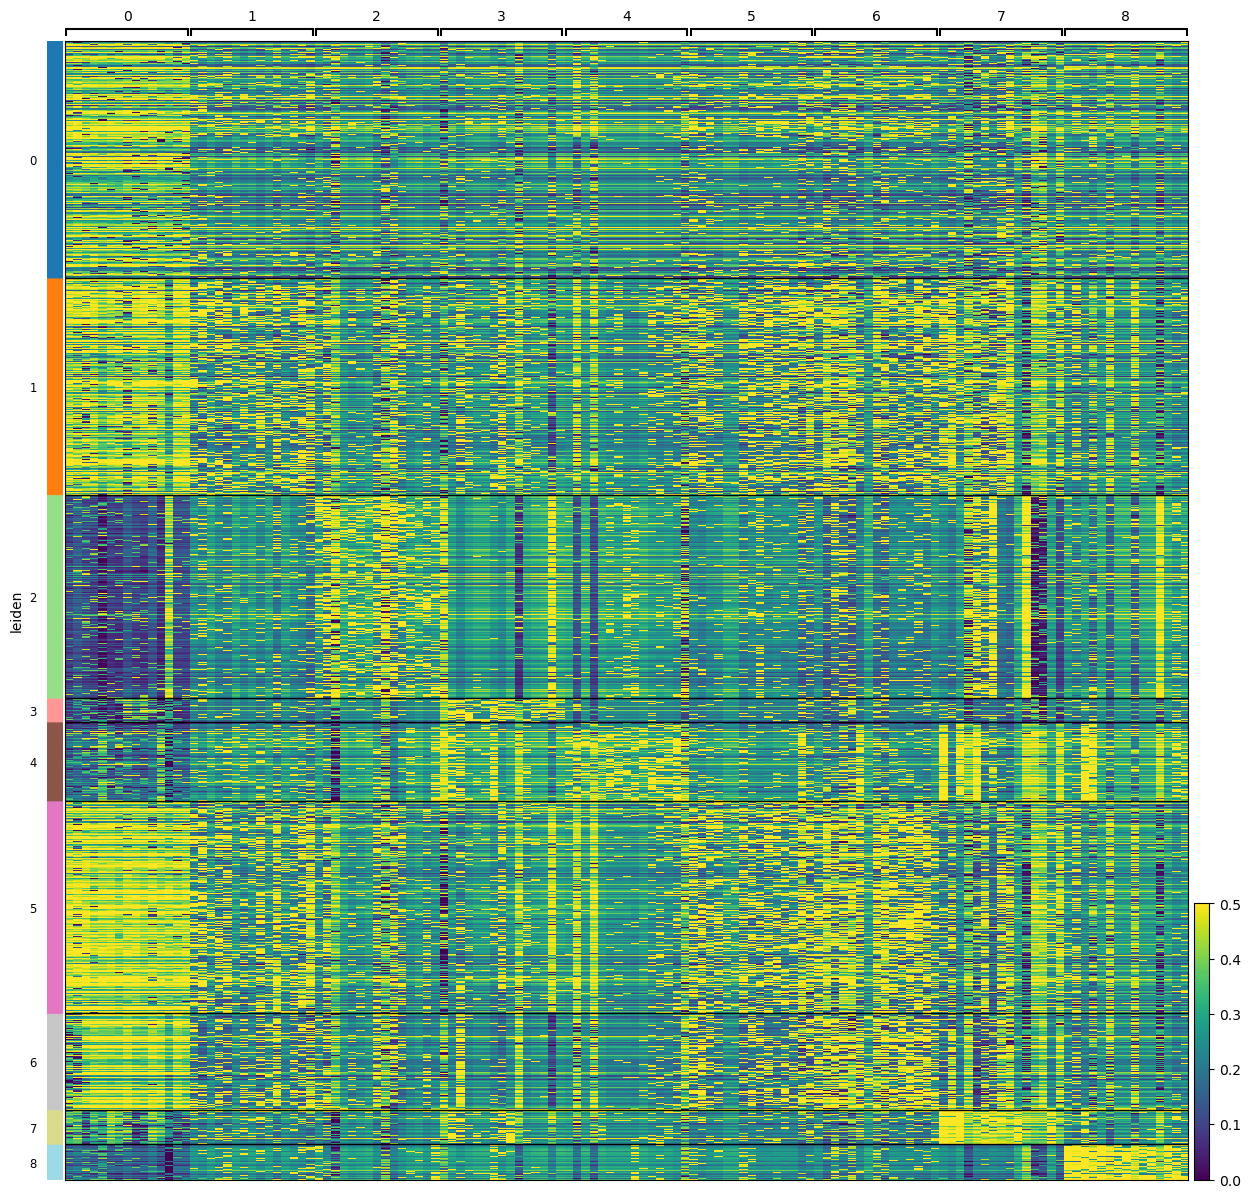

scores  logfoldchanges          pvals      pvals_adj
leiden names                                                                  
5      Smurf1          52.179630        1.787631   0.000000e+00   0.000000e+00
       Arl3            52.371861        1.716211   0.000000e+00   0.000000e+00
       Pfkm            52.359268        1.858708   0.000000e+00   0.000000e+00
       Usf3            52.342121        1.884558   0.000000e+00   0.000000e+00
       Ccn3            52.329323        3.249097   0.000000e+00   0.000000e+00
       Gm12371         52.299938        3.280986   0.000000e+00   0.000000e+00
       Ubac2           52.276756        1.724732   0.000000e+00   0.000000e+00
       Entr1           52.269951        1.826661   0.000000e+00   0.000000e+00
       Tmem151a        52.265415        1.772315   0.000000e+00   0.000000e+00
       Nceh1           52.231071        1.787486   0.000000e+00   0.000000e+00
       Pls3            52.228706        1.889730   0.000000e+00   0.000000e+00
       Mrpl41          52.227352        1.842142   0.000000e+00   0.000000e+00
       Ncs1            52.216713        1.837653   0.000000e+00   0.000000e+00
       Adk             52.202930        1.626228   0.000000e+00   0.000000e+00
       Btbd7           52.185795        1.655978   0.000000e+00   0.000000e+00
1      Ipo9            49.887600        1.806189   0.000000e+00   0.000000e+00
       Kif16b          49.997070        1.691769   0.000000e+00   0.000000e+00
       Slc39a6         49.989765        2.303841   0.000000e+00   0.000000e+00
       Ssb             49.983730        1.716834   0.000000e+00   0.000000e+00
       Ubac2           49.975971        1.678680   0.000000e+00   0.000000e+00
       9330159M07Rik   49.970547        2.704767   0.000000e+00   0.000000e+00
       Erp29           49.963879        1.781210   0.000000e+00   0.000000e+00
       Gpc1            49.954193        2.234042   0.000000e+00   0.000000e+00
       Reps1           49.947380        1.714474   0.000000e+00   0.000000e+00
       Vstm5           49.922413        2.318811   0.000000e+00   0.000000e+00
       Mapkap1         49.919682        1.612838   0.000000e+00   0.000000e+00
       Tmem169         49.919678        2.276560   0.000000e+00   0.000000e+00
       Clpx            49.903904        1.756471   0.000000e+00   0.000000e+00
       Map3k7          49.903728        1.696558   0.000000e+00   0.000000e+00
       Btaf1           49.999718        1.586228   0.000000e+00   0.000000e+00
0      Nrg3           142.452026        4.107781   0.000000e+00   0.000000e+00
       Dpp10          138.951385        4.910851   0.000000e+00   0.000000e+00
       Kcnip4         138.293945        4.104700   0.000000e+00   0.000000e+00
       Rbfox1         137.393112        3.926455   0.000000e+00   0.000000e+00
       Celf2          131.670334        3.144436   0.000000e+00   0.000000e+00
       Csmd1          128.779266        3.637968   0.000000e+00   0.000000e+00
       Nrxn3          125.969872        3.488383   0.000000e+00   0.000000e+00
       Nrg1           113.331749        3.747945   0.000000e+00   0.000000e+00
       Syt1           112.355385        3.356306   0.000000e+00   0.000000e+00
       Meg3           111.013176        3.171908   0.000000e+00   0.000000e+00
       Sgcz           100.021637        3.458776   0.000000e+00   0.000000e+00
       Fgf14           99.979164        2.813265   0.000000e+00   0.000000e+00
       Ptprd           97.597748        1.844778   0.000000e+00   0.000000e+00
       Cntnap2         93.390694        2.978568   0.000000e+00   0.000000e+00
       Snhg11          90.035690        2.944553   0.000000e+00   0.000000e+00
2      Kcnk13          59.093266        3.053705   0.000000e+00   0.000000e+00
       Ywhaq           56.939629        2.365501   0.000000e+00   0.000000e+00
       App             57.157963        1.881855   0.000000e+00   0.000000e+00
       Mboat1          57.354801        4.658205   0.000000e+00   0.000000e+

In [23]:
markers_df = self.get_markers_df(
    n_genes=15, col_celltype=col_celltype,
    p_threshold=1e-10, log2fc_threshold=1.5, log2fc_threshold_abs=False)
markers_dict = dict(markers_df.groupby(col_celltype).apply(
    lambda x: list(x.reset_index().names)))
_ = self.plot(genes=markers_dict, figsize=(15, 15), vmin=0, vmax=0.5,
              layer="scaled", standard_scale="obs", kind="heat")
markers_df

## Annotate by Marker Gene Overlap

File from https://github.com/nasa/GeneLab_Data_Processing/blob/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files/GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv

**Example of the Expected Marker Definition Format**
```
markers_predefined = {
    "CD4 T cells": {"IL7R"},
    "CD14+ Monocytes": {"CD14", "LYZ"},
    "B cells": {"MS4A1"},
    "CD8 T cells": {"CD8A"},
    "NK cells": {"GNLY", "NKG7"},
    "FCGR3A+ Monocytes": {"FCGR3A", "MS4A7"},
    "Dendritic Cells": {"FCER1A", "CST3"},
    "Megakaryocytes": {"PPBP"},
}
```

annotation_by_overlap
Neuron             66.99
Oligodendrocyte    17.87
Astrocyte           6.93
Microglial          3.10
OPC                 3.02
Endothelial         2.09
Name: proportion, dtype: float64


leiden  annotation_by_overlap
3       Endothelial               2.09
7       OPC                       3.02
8       Microglial                3.10
4       Astrocyte                 6.93
6       Neuron                    8.48
2       Oligodendrocyte          17.87
5       Neuron                   18.66
1       Neuron                   19.02
0       Neuron                   20.84
Name: proportion, dtype: float64

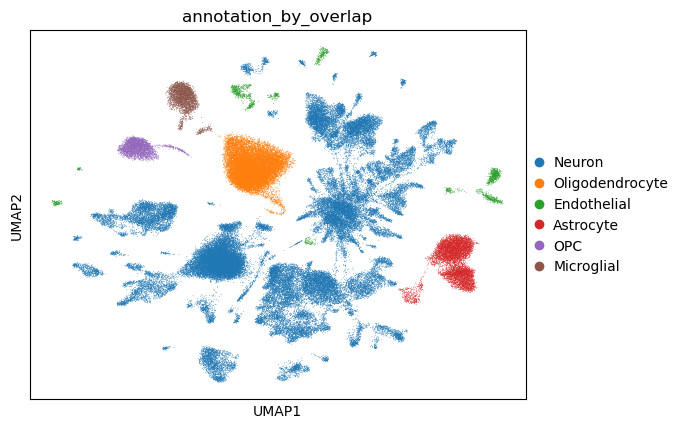

In [30]:
# Annotate
marker_matches = self.annotate(
    mks_collapsed,
    # celltypes_superhierarchical=celltypes_superhierarchical,
    col_celltype=col_celltype, col_celltype_new="annotation_by_overlap",
    top_n_markers=50,  # can only have this one or `adj_pval_threshold`
    # adj_pval_threshold=1e-10,
    # method="overlap_coef",
    method="overlap_count",
    overwrite=True)

# Rename Any Labels As Pre-Specified
if rename_marker_based_annotation is not None:
    self.rna.obs.loc[:, "annotation_by_overlap"] = self.rna.obs[
        "annotation_by_overlap"].replace(rename_marker_based_annotation)

# Print & Plot Results
self.plot(kind="umap", color="annotation_by_overlap", wspace=0.4)
print(round(self.rna.obs["annotation_by_overlap"].value_counts(
    normalize=True) * 100, 2))
round(self.rna.obs[[col_celltype, "annotation_by_overlap"]
                   ].value_counts(normalize=True)* 100, 2).sort_values()

## Annotate with ToppGene

In [37]:
# Options
min_genes = 2  # minimum markers that have to overlap between Leiden & atlas
remove_strings = ["----L1-6", # "---[|]M.*",
                  "facs-", "-nan-",
                  # "-i_Gaba_3-.*",
                  "Brain_organoid-organoid_Kanton_Nature-Organoid-..-",
                  # "Non-neuronal-Macroglial-((^|)(Oligo|Astro))+-",
                  # "-Glut_E.*IL7R",
                  "cells hierarchy compared to all cells using T-S.*",
                  ".*-organoid_Tanaka_cellReport-.+-",
                  "...BrainAtlas -.*", "-eN2.*", "...Sample groups.*",
                  "...Sample Type, Dataset.*",
                  "-Neuronal",
                  " // Primary Cells by Cluster",
                  ".World...Primary Cells by Cluster",
                  "Brain_organoid-organoid_Velasco_nature-6_",
                  "Fetal_brain-fetalBrain_Zhong_nature-....-",
                  "Somatosensory_Cortex_....-Neuronal-",
                  "Non-neuronal-Non-dividing-",
                  "...Sample groups..6 Anatomical region groups., with 5.*",
                  "Brain_organoid-organoid_Paulsen_bioRxiv-",
                  "-Glut_E_(THEMIS)", "[(]THEMIS[)]",  # "[|].*",
                  "- method, tissue, subtissue, age, lineage.*"]
drop_name_patterns = ["striatum", "globus", "Entopeduncular",
                      "Substantia_nigra-", "Thalamus-"]
toppgene_rename_by_pattern = dict(
    Inhibitory=["Inh(_|ib)", "GABA"], Excitatory=["Excit", "Glut"],
    # Inhibitory=["Inh(_|ib)"], Excitatory=["Excit"],
    # # Gabaergic=["GABA"], Glutamatergic=["Glut"],
    Astrocyte=["Astrocyte","Astroglia", "Macroglial-Astro"],
    Microglial=["Microglia", "Micro"],
    Endothelial=["Endothelial"],
    Oligodendrocyte=[r"^(?=.*oligo)(?!.*poly)(?!.*opc).*"],
    OPC=["Polydendrocyte", "OPC"])
drop_regions = [
    "Mid-temporal_gyrus_(MTG)", "primary_auditory_cortex_(A1C)",
    "Somatosensory_Cortex_(S1)", "Anterior_Cingulate_gyrus_(CgG)",
    "Primary_Motor_Cortex_(M1)",
    "Mid-temporal_gyrus_(MTG)|Mid-temporal_gyrus_(MTG)",
    "primary_auditory_cortex_(A1C)|primary_auditory_cortex_(A1C)",
    "Somatosensory_Cortex_(S1)|Somatosensory_Cortex_(S1)",
    "Anterior_Cingulate_gyrus_(CgG)|Anterior_Cingulate_gyrus_(CgG)",
    "Primary_Motor_Cortex_(M1)|Primary_Motor_Cortex_(M1)",
    r"Neuronal|World / ",
    "Primary_Visual_cortex_(V1C)|Primary_Visual_cortex_(V1C)",
    "mon",
    "BMP_responsible_cell|6m", "bearing_cell|6m", "bearing_cell|GW16", "11",
    "Non-neuronal-Non-dividing",
    "Frontal_cortex|Frontal_cortex",
    "Primary_Visual_cortex_(V1C)", "Substantia_nigra",
    "Thalamus", "Hippocampus", "Frontal_cortex"
]  # remove if name is just a region or top-level hierarchical/undesired type
drop_regions = drop_regions + [f"{i}-Non-neuronal" for i in drop_regions]

# Query ToppGene
results_toppgene = scflow.pp.annotate_by_toppgene(
    markers_dict, remove_strings=remove_strings,
    species=species, min_genes=min_genes, source_patterns=source_patterns)

# Remove or Alter Certain Name Patterns
drop_names = results_toppgene.Name.apply(lambda x: not any((
    i.lower() in x.lower() for i in drop_name_patterns)))
results_toppgene = results_toppgene[drop_names]
rn_tg = results_toppgene.Name.apply(lambda x: {x: " | ".join([
    j for j in toppgene_rename_by_pattern if any((re.search(i.lower(
        ), x.lower()) is not None for i in toppgene_rename_by_pattern[
            j]))])}).apply(lambda x: np.nan if x[list(x.keys())[
                0]] == "" else x).dropna().reset_index(drop=True).apply(
                    lambda x: pd.Series(x)).stack().reset_index(
                        0, drop=True)  # renaming guide
results_toppgene = results_toppgene.replace({"Name": dict(rn_tg)})
results_toppgene = results_toppgene[~results_toppgene.Name.isin(drop_regions)]

# Map Labels (Plurality Vote If Sufficient or Top)
top_cs = dict(results_toppgene.groupby(
    "Gene Set").apply(lambda x: x.Name.iloc[:10].value_counts().index.values[
        0] if x.Name.iloc[:10].value_counts(
            normalize=True).iloc[0] >= 0.25 else x.Name[0]))
print("\n".join([f"{k}: {top_cs[k]}" for k in top_cs]), "\n\n")
if "annotation_toppgene" in self.rna.obs:
    self.rna.obs = self.rna.obs.drop("annotation_toppgene", axis=1)
self.rna.obs = self.rna.obs.join(self.rna.obs[col_celltype].replace(
    top_cs).to_frame("annotation_toppgene")).loc[self.rna.obs.index]

# Display Results
if "annotation_by_overlap" in self.rna.obs:
    print(round(self.rna.obs[["annotation_toppgene", "annotation_by_overlap"]
                             ].value_counts(normalize=True).sort_index(
                                 ) * 100, 2), "\n\n")
print(round(self.rna.obs["annotation_toppgene"].value_counts(
    normalize=True) * 100, 2))
results_toppgene.reset_index("ID", drop=True).drop([
    "QValueBonferroni", "QValueFDRBY", "QValueFDRBH",
    "TotalGenes", "Genes"], axis=1)

Server returned HTTP status code: 400
Content: {'error': 'No valid lookup found for symbol Qk'}
Server returned HTTP status code: 400
Content: {'error': 'No valid lookup found for symbol Fyb'}
Server returned HTTP status code: 400
Content: {'error': 'No valid lookup found for symbol Qk'}
0: OPC
2: Oligodendrocyte
3: Excitatory
4: Astrocyte
6: Excitatory
7: OPC
8: Microglial 


annotation_toppgene  annotation_by_overlap
OPC                  Neuron                   20.84
                     OPC                       3.02
1                    Neuron                   19.02
Oligodendrocyte      Oligodendrocyte          17.87
Excitatory           Neuron                    8.48
                     Endothelial               2.09
Astrocyte            Astrocyte                 6.93
5                    Neuron                   18.66
Microglial           Microglial                3.10
Name: proportion, dtype: float64 


annotation_toppgene
OPC                23.86
1                  19.02
5  

Name    PValue GenesInTerm GenesInQuery GenesInTermInQuery                                             Source  \
Gene Set Category                                                                                                                                                               
0        ToppCell                                         Excitatory       0.0         195           14                  9      Human Adult Multiple Cortical Areas SMART-seq   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                                                OPC       0.0         200           14                  6                              Human Adult Brain MTG   
         ToppCell                  Substantia_nigra|Substantia_nigra       0.0         186           14                  5  Mouse Adult Brain Overview (690k cells, 9 regi...   
         ToppCell                                         Excitatory       0.0         192           14                  5      Human Adult Multiple Cortical Areas SMART-seq   
         ToppCell                                         Inhibitory       0.0         194           14                  5           Comparison of human cortex and organoids   
         ToppCell                                         Inhibitory       0.0         194           14                  5           Comparison of human cortex and organoids   
         ToppCell                                             Neuron       0.0         199           14                  5           Comparison of human cortex and organoids   
         ToppCell                                 Neuron-Postmitotic       0.0         199           14                  5           Comparison of human cortex and organoids   
         ToppCell                                         Excitatory       0.0         200           14                  5           Comparison of human cortex and organoids   
         ToppCell      Fetal_brain-fetalBrain_Zhong_nature-GW16|GW16       0.0         200           14                  5  Integration of Four Brain Organoid Datasets an...   
         ToppCell                                         Excitatory       0.0         200           14                  5           Comparison of human cortex and organoids   
         ToppCell                               Cortical_neuron|GW09       0.0         200           14                  5  Integration of Four Brain Organoid Datasets an...   
         ToppCell      Fetal_brain-fetalBrain_Zhong_nature-GW23|GW23       0.0         112           14                  4  Integration of Four Brain Organoid Datasets an...   
2        ToppCell                                    Oligodendrocyte       0.0         190           15                  4      Human Adult Multiple Cortical Areas SMART-seq   
         ToppCell                                                OPC  0.000008         119           15                  3  Mouse Adult Brain Overview (690k cells, 9 regi...   
         ToppCell                                                OPC  0.000008         119           15                  3  Mouse Adult Brain Overview (690k cells, 9 regi

## Annotate with CellTypist

In [ ]:
# %%time

# # To Aggregate More Specific Cell Types
# celltypist_rename = dict(
#     Gabaergic=["GABA"], Glutamatergic=["Glut"],
#     Dopaminergic=["Dopa"], Serotonergic=["Sero"],
#     Inhibitory=["Inh"], Excitatory=["Exc"],
#     Astrocyte=["Astro"],
#     Microglia=["Microglia"],
#     Pericyte=["peri"],
#     Monocyte=["Monocyte"],
#     Lymphoid=["Lymphoid"],
#     Endothelial=["Endothelial"],
#     Oligodendrocyte=[r"^(?=.*oligo)(?!.*poly)(?!.*opc).*"],
#     Polydendrocyte=["OPC"])

# # Run CellTypist
# self.rna.X = self.rna.layers["counts"].copy()
# sc.pp.normalize_total(self.rna, target_sum=10000)
# sc.pp.log1p(self.rna) # copy=True: do not update adata.X
# predictions = self.annotate(
#     model_celltypist, col_celltype=col_celltype, layer=None,
#     col_celltype_new="", majority_voting=True, min_prop=0.5, use_GPU=True)
# if "majority_voting" in self.rna.obs:
#     self.rna.obs.loc[:, "majority_voting_short"] = self.rna.obs[
#         "majority_voting"].apply(lambda x: " ".join(x.split(
#             " ")[1:]) if all((i in [str(i) for i in np.arange(
#                 0, 10)] for i in x.split(" ")[
#                     0])) else x)  # drop pointless #s in front of cell types

# # Rename Cell Types
# rn_ct = predictions.predicted_labels.groupby("majority_voting").apply(
#     lambda x: {x.name: " | ".join([
#         j for j in celltypist_rename if any((re.search(
#             i.lower(), x.name.lower()) for i in celltypist_rename[
#                 j]))])}).apply(lambda x: {list(x.keys())[0]: list(x.keys(
#                     ))[0]} if x[list(x.keys())[0] ] == "" else x).apply(
#                         lambda x: pd.Series(x)).stack().reset_index(
#                             0, drop=True)
# if "annotation_majority_voting" in self.rna.obs:
#     self.rna.obs = self.rna.obs.drop("annotation_majority_voting", axis=1)
# self.rna.obs = self.rna.obs.join(self.rna.obs.replace({
#     "majority_voting": dict(rn_ct)})["majority_voting"].to_frame(
#         "annotation_majority_voting"))
# self.rna.X = self.layers["scaled"].copy()

## Annotate with Map My Cells

- Make sure to run the following bash commonds after activating the conda environment used for this notebook.

- Pull [`cell_type_mapper`](https://github.com/AllenInstitute/cell_type_mapper) from GitHub (clone into your home directory): `cd && git clone git@github.com:AllenInstitute/cell_type_mapper.git`

- Navigate to that directory and run `pip install .`

- Navigate to the folder containing this notebook.

- Install ABC Atlas (while in same directory as this notebook): `pip install -U git+https://github.com/alleninstitute/abc_atlas_access >& scratch/junk.txt`

- Pull lookup files (while in same directory as this notebook):
```
cd resources
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/mouse_markers_230821.json
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/precomputed_stats_ABC_revision_230821.h5
```

---

Note: To use GPU + Torch, you may need to alter the file "cell_type_mapper/src/cell_type_mapper/cell_by_gene/cell_by_gene.py" line `np.where(np.logical_not(np.isfinite(data)))[0]` to read instead

```
try:
    nan_rows = np.where(
        np.logical_not(np.isfinite(data.cpu().numpy())))[0]
except Exception:
    nan_rows = np.where(np.logical_not(np.isfinite(data)))[0]
```

You may have to run the following code in this notebook:

```
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
```

and

    `_correlation_dot_gpu()` in distance_utils.py change
    `correlation = torch.matmul(arr0, arr1)` to

```
try:
    correlation = torch.matmul(arr0, arr1)
except RuntimeError as err:
    if "CUBLAS_STATUS_NOT_INITIALIZED" in str(err):
        arr0_cpu = arr0.cpu()
        arr1_cpu = arr1.cpu()
        correlation = torch.matmul(arr0_cpu, arr1_cpu).to(arr0.device)
    else:
        raise
```

to manage processes/memory.

In [ ]:
# %%time

# # Write File to Use as Input for Map My Cells
# if overwrite is True or not os.path.exists(file_new):
#     os.makedirs("data", exist_ok=True)
#     self.rna.X = self.rna.layers["counts"]
#     self.rna.write_h5ad(file_new)
# else:
#     raise ValueError("Must be able to overwrite to run Map My Cells.")

# # Run Map My Cells
# self.rna = scflow.pp.run_mapbraincells(
#     file_new, map_my_cells_source=map_my_cells_source,
#     dir_scratch="scratch", dir_resources="resources",
#     validate_output_file="scratch/tmp.h5ad",  # map_to_ensembl=True,
#     map_my_cells_region_keys=map_my_cells_region_keys,
#     map_my_cells_cell_keys=map_my_cells_cell_keys, verbose_stdout=True,
#     n_processors=4, chunk_size=5000, max_gb=5)

# View Results
# _ = self.plot(kind="umap", color=["cellmap_class_name"])
# if "annotation_toppgene" in self.rna.obs:
#     print(self.rna.obs[["cellmap_class_name", "annotation_toppgene"]
#                        ].value_counts().sort_index())
# self.rna.obs[[i for i in self.rna.obs if "cellmap" in i and "ori" not in i]]

## Compare Annotations

annotation_by_overlap  annotation_toppgene
Neuron                 OPC                    21527
                       1                      19639
                       Excitatory              8753
                       5                      19269
Oligodendrocyte        Oligodendrocyte        18451
Endothelial            Excitatory              2158
Astrocyte              Astrocyte               7160
OPC                    OPC                     3117
Microglial             Microglial              3200
Name: count, dtype: int64

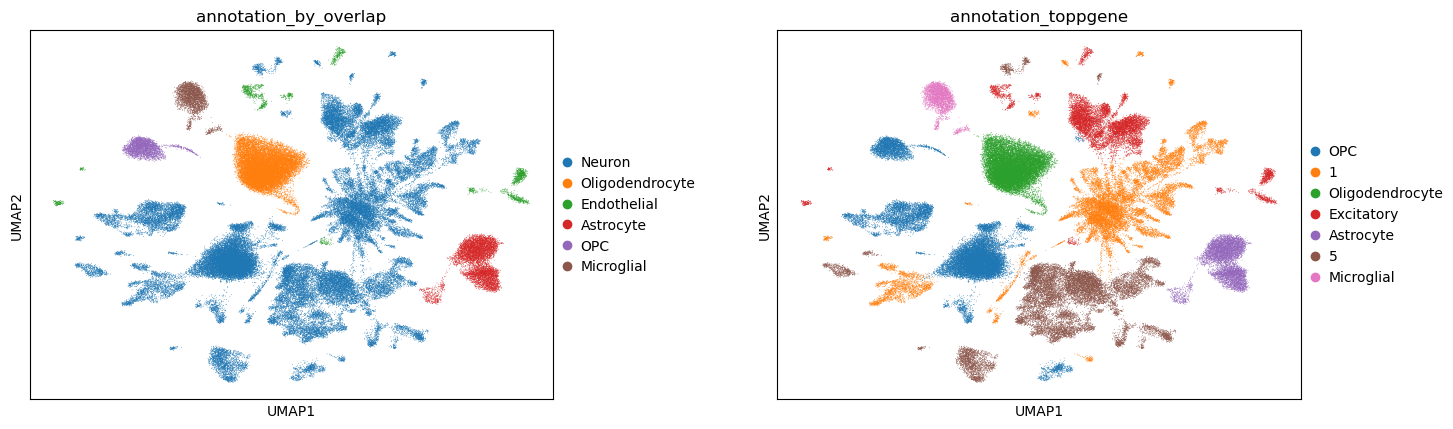

In [38]:
cols = [i for i in ["annotation_by_overlap", "annotation_toppgene",
                    "annotation_majority_voting"] if i in self.rna.obs]
# cols += [i for i in [
#     "cellmap_class_name", "cellmap_subclass_name"] if i in self.rna.obs]

# Plot UMAPs
self.plot(kind="umap", color=cols, wspace=0.3)

# Compare
self.rna.obs[cols].value_counts().sort_index()

# OSD-613-Specific

Clean variable names & keys

In [39]:
self.rna.obs.loc[:, "Age_Start"] = self.rna.obs["Factor Value[Age]"].astype(
    str) + " Weeks"
self.rna.obs.loc[:, "Age_End"] = self.rna.obs[
    "Characteristics[Age at Euthanasia]"].astype(str) + " Weeks"
self.rna.obs.loc[:, "Condition"] = self.rna.obs["Factor Value[Spaceflight]"]
if "cellmap_class_name" in self.rna.obs:  # cell name w/o region cues
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name"].apply(lambda x: x + "***" + str(
            "Glutamatergic-" if ("glut" in x.lower()) else "") + str(
                "GABAergic-" if "gaba" in x.lower() else "") + str(
                    "Oligodendrocyte-" if "oligo" in x.lower() else "") + str(
                        "Cholinergic-" if "chol" in x.lower() else ""))
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name_collapsed"].apply(
            lambda x: x.split("***")[0 if x.split("***")[1] == "" else 1])
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name_collapsed"].apply(
            lambda x: x[:-1] if x[-1] == "-" else x)

# Test

Make sure preprocessing properly implemented

In [ ]:
# for x in kws_pp:
#     print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n")
#     ann = self.rna[self.rna.obs[col_sample] == x]
#     if join_method == "inner":
#         assert all(ann.var["n_cells_by_counts"] >= kws_pp[
#             x]["min_max_cells"][0])
#         assert all(ann.var["n_cells_by_counts"] <= kws_pp[
#             x]["min_max_cells"][1]) if kws_pp[x]["min_max_cells"][1] else True
#     assert all(ann.obs["n_genes"] >= kws_pp[x]["min_max_genes"][0])
#     assert all(ann.obs["n_genes"] <= kws_pp[x][
#         "min_max_genes"][1]) if kws_pp[x]["min_max_genes"][1] else True
#     assert all(ann.obs["pct_counts_mt"] <= kws_pp[x]["max_mt"])
#     assert all(ann.obs["total_counts"] >= kws_pp[x]["min_max_counts"][0])
#     assert all(ann.obs["total_counts"] <= kws_pp[x]["min_max_counts"][1]) if (
#         kws_pp[x]["min_max_counts"][1]) else True
#     print(kws_pp[x])
#     print(ann.obs[["n_genes", "pct_counts_mt", "total_counts"]
#                   ].describe().loc[["min", "max"]])
#     print(ann.var[["n_cells_by_counts"]].describe().loc[[
#         "min", "max"]])

# Final Write

In [ ]:
# Descriptives
if all((i in self.rna.obs for i in [
        "Factor Value[Age]", "Characteristics[Age at Euthanasia]"])):
    print(self.rna.obs[["Factor Value[Age]",
                        "Characteristics[Age at Euthanasia]"]].value_counts())

# Write h5ad
self.rna.X = self.rna.layers["counts"].copy()
if overwrite is True or not os.path.exists(file_new):
    print("\n\n", f"Writing file to {file_new}...")
    self.rna.write_h5ad(file_new)

# Write Version Compatible with Older Packages
adata = self.rna.copy()
adata.uns = {}
adata.write_h5ad(os.path.splitext(file_new)[0] + "_compatible.h5ad")

# Send Email with Output When Done
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

Factor Value[Age]  Characteristics[Age at Euthanasia]
29                 37                                    55266
12                 20                                    48008
Name: count, dtype: int64


 Writing file to data/OSD-613_integrated.h5ad...


[NbConvertApp] Converting notebook /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/create_object_613.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 33 image(s).
[NbConvertApp] Writing 7166762 bytes to /home/easlinger/AWG/ADBR/Brain_AWG/Senescence/create_object_613.html
Authenticating (PLAIN)...


# Scratch (IGNORE)

In [ ]:
# # Integrate
# join_method = "inner"
# cct = "leiden_individual" if kws_cluster is not None else None
# kws_integrate = {"col_celltype": cct,
#                  "flavor": "scanvi",
#                  # "flavor": "scvi",
#                  # "flavor": "scanorama",
#                  # "flavor": "harmony",
#                 "kws_pp": None, "kws_cluster": None, "n_top_genes": 1000,
#                  "join": join_method, "merge": "same",
#                  "col_batch": None,  # suppress using batch as covariate
#                  "drop_non_hvgs": False,
#                  "use_rapids": True,
#                  "fill_value": np.nan if join_method == "outer" else None,
#                  "out_file": file_new}
# self = scflow.Rna(sc.read(file_new), col_sample=col_sample,
#                   col_batch=col_batch, kws_integrate=kws_integrate)

# # Write Files for Processed/Integrated Objects?
# if overwrite is True or not os.path.exists(file_new):
#     self.rna.write_h5ad(file_new)

# # Display
# print(self.rna)
# self.rna.obs